In [2]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [3]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Parsers as P, Utilities as U
from mppi.Calculators import Tools
from mppi.Datasets import PostProcessing as PP
from mppi.Utilities import Constants as Const
from mppi.Utilities import LatticeUtils as LL
import matplotlib.pyplot as plt
import numpy as np
import os, yaml
from scipy.signal import argrelextrema

In [ ]:
# RunRules for local computations
mpi = 4
omp = 2

rr = C.RunRules(omp_num_threads=omp,mpi=mpi)
code = C.QeCalculator(rr)
#code.global_options()

In [4]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 16
cpus_per_task=2
omp_num_threads=2
module = '/home/dalessandro/module_script/qe_module'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h',
                memory='125000',time='11:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads,pre_processing=module)
code = C.QeCalculator(rr,activate_BeeOND=True) #,skip=False,clean_restart=False
code.global_options()

Initialize a QuantumESPRESSO calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 16,
 'cpus_per_task': 2,
 'omp_num_threads': 2,
 'gpus_per_node': None,
 'memory': '125000',
 'time': '11:59:00',
 'partition': 'all12h',
 'account': None,
 'qos': None,
 'map_by': None,
 'pe': 1,
 'rank_by': None,
 'pre_processing': '/home/dalessandro/module_script/qe_module',
 'executable': 'pw.x',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': True,
 'verbose': True}

In [5]:
# RunRules for m100
nodes = 1
ntasks_per_node = 4
cpus_per_task=32
omp_num_threads=8
gpus_per_node=4
pe=8

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='m100_usr_prod',
                account='IscrC_AlNWS2',
                memory='120GB',time='23:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gpus_per_node=gpus_per_node,pe=pe,
                map_by='socket',rank_by='core')
code = C.QeCalculator(rr)
#code.global_options()

# DFT analysis of the 2D MoS$_2$

This notebook contains the DFT analysis of the 2D MoS$_2$ performed with QuantumESPRESSO

## Lattice properties and atomic positions

We use the lattice configuration adopted by QuantumESPRESSO in the ibrav=4 case.

The basis vector of the (direct) lattice are defined as
$$
a_1 = a_{lat}(1,0,0) \, ,\quad a_2 = a_{lat}(\frac{-1}{2},\frac{\sqrt{3}}{2},0) \, ,\quad
a_3 = a_{lat}(0,0,\frac{c}{a_{lat}})
$$
so that $c$ vacuum space between two replica of the sheets, expressed in the same units as $a_{lat}$.
We also observe that $\textrm{celldm(3)}=c/a_{lat}$, so it expresses the vacuum distance in terms of 
$a_{lat}$.

The cartesian component of the reciprocal lattice vectors (in units of $2\pi/a_{alat}$) are given by:

$$
b_1 = (1,\frac{1}{\sqrt{3}}) \, ,\quad b_2 = (0,\frac{2}{\sqrt{3}},0) \, ,\quad
b_3 = (0,0,\frac{a}{c})
$$
The reciprocal vectors have module $2/\sqrt{3}$.

The cartesian coordinates of the high symmetry points of the reciprocal lattice (in units of $2\pi/a_{alat}$) 
can be determined by performing the construction of the Brillouin zone: we find the points on at the half of
the $b_1$ and $b_2$ vectors and build the path moving perpendicularly to the basis vector directions.
The $M$ point (at the middle of the hexagon face) and the $K$ point (the edge point) are given by:
$$
M = (\frac{1}{2},\frac{1}{2\sqrt{3}}) \, \quad
K = (\frac{2}{3},0) 
$$
Moreover we write the coordinates of the symmetry related K' point (which corresponds to another edge of the hexagon)
and M' point (middle point of the top edge of the hexagon): 
$$
K' = (\frac{1}{3},\frac{1}{\sqrt{3}}) \, \quad
M' = (0,\frac{1}{\sqrt{3}}) 
$$
These points, together with $\Gamma$ define the IBZ edges in the representation of QuantumESPRESSO.

In cartesian coordinates the atomic positions read
$$
Mo = a_{lat}(0,\frac{1}{\sqrt{3}},0) \, \qquad S_1 = a_{lat}(\frac{1}{2},\frac{1}{2\sqrt{3}},\delta) \, \quad
S_2 = a_{lat}(\frac{1}{2},\frac{1}{2\sqrt{3}},-\delta)
$$
where $\delta$ is the buckling of the $S$ atoms in units of $a_{lat}$. Converted in crystal coordinates the atomic positions read
$$
Mo_{cryst} = (\frac{1}{3},\frac{2}{3},0) \, \qquad S_{1-cryst} = (\frac{2}{3},\frac{1}{3},\delta_{cryst}) \, \quad
S_{2-cryst} = (\frac{2}{3},\frac{1}{3},-\delta_{cryst})
$$
where $\delta = (c/a_{lat})\delta_{cryst}$, so the cartesian buckling is equal to the crystal one multiplied times celldm(3).

## GS Analysis

We analyze the electronic configuration of the GS.

In [4]:
pseudo_dir = '../pseudos'
Mo_pseudo = 'Mo-fr.out'
S_pseudo = 'S-fr.out'

According to the results provided by Fulvio Paleari the converged atomic positions read 

In [33]:
alat = 5.9000811881 # in a.u. (Bohr)
c = 40.0 # vacuum distance in a.u. 
celldm3 = c/alat # in units of alat
delta_cryst = 0.073413577 # buckling in crystal coordinates
delta = celldm3*delta_cryst

Atomic positions in cartesian and crystal coordinates and lattice vectors

In [6]:
# cartesian coordinates expressed in units of alat
Mo_cart = np.array([0,1./np.sqrt(3.),0.])
S1_cart = np.array([1./2.,1./(2*np.sqrt(3.)),delta])
S2_cart = np.array([1./2.,1./(2*np.sqrt(3.)),-delta])

# crystal coordinates
Mo_cryst = np.array([1./3.,2./3.,0.])
S1_cryst = np.array([2./3.,1./3.,delta_cryst])
S2_cryst = np.array([2./3.,1./3.,-delta_cryst])

lattice = alat*np.array([[1,0,0],[-1./2.,np.sqrt(3)/2.,0],[0,0,celldm3]])
atoms = [['Mo',alat*Mo_cart],['S',alat*S1_cart],['S',alat*S2_cart]]

We plot the lattice in xy and xz directions

In [7]:
positions = LL.build_lattice(lattice,atoms,8,8,1)
#positions

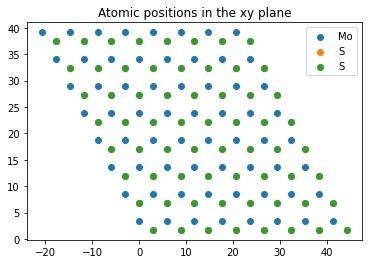

In [8]:
for pos in positions:
    plt.scatter(pos[1],pos[2],label=pos[0])
plt.title('Atomic positions in the xy plane',size=12)
plt.legend()

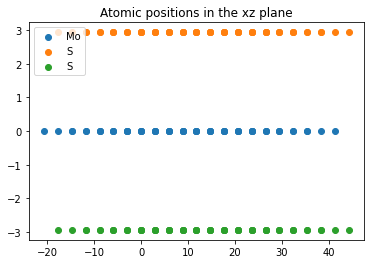

In [9]:
for pos in positions:
    plt.scatter(pos[1],pos[3],label=pos[0])
plt.title('Atomic positions in the xz plane',size=12)
plt.legend()

### Convergence procedure on the $k$-points sampling and of energy cutoff of the wave functions

We perform a set of calculations in functions of the number of k-points and of the energy cutoff and we find
the converged values using the total ground state energy, the gap at $K$ and the gap at $\Gamma$ as control quantities.

In [13]:
run_dir = 'DFT_analysis'

We build the basic elements of the input 

In [14]:
inp = I.PwInput()
inp.set_scf(force_symmorphic=True,conv_thr=1e-6)
inp.set_num_bnds(28)
inp.set_pseudo_dir(pseudo_dir=pseudo_dir)
inp.set_spinorbit()
inp.add_atom(atom='Mo',pseudo_name=Mo_pseudo,mass=42.00)
inp.add_atom(atom='S',pseudo_name=S_pseudo,mass=16.00)
inp.set_atoms_number(3)
inp.set_atomic_positions([['Mo',Mo_cart],['S',S1_cart],['S',S2_cart]],type='alat')
#inp.set_atomic_positions([['Mo',Mo_cryst],['S',S1_cryst],['S',S2_cryst]],type='crystal')
inp.set_lattice(ibrav=4,celldm1=alat,celldm3=celldm3)
inp

{'control': {'calculation': "'scf'",
  'verbosity': "'high'",
  'prefix': "'pwscf'",
  'outdir': "'./'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'nbnd': 28,
  'lspinorb': '.true.',
  'noncolin': '.true.',
  'ntyp': '2',
  'nat': '3',
  'ibrav': 4,
  'celldm(1)': 5.9000811881,
  'celldm(3)': 6.779567725386027},
 'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
 'ions': {},
 'cell': {},
 'atomic_species': {'Mo': [42.0, 'Mo-fr.out'], 'S': [16.0, 'S-fr.out']},
 'atomic_positions': {'type': 'alat',
  'values': [['Mo', array([0.        , 0.57735027, 0.        ])],
   ['S', array([0.5       , 0.28867513, 0.49771232])],
   ['S', array([ 0.5       ,  0.28867513, -0.49771232])]]},
 'kpoints': {},
 'cell_parameters': {}}

In [15]:
kvalues = [12,15]
ecut = [40,60,80,100,120]

In [16]:
study = D.Dataset(run_dir=run_dir,num_tasks=4)

for k in kvalues:
    for e in ecut:
        idd = {'ecut' : e, 'k' : k}
        inp.set_prefix(D.name_from_id(idd))
        inp.set_kpoints(type='automatic',points=[k,k,1])
        inp.set_energy_cutoff(e)
        study.append_run(id=idd,input=inp,runner=code)
    
study.set_postprocessing_function(PP.pw_parse_data)

Initialize a Dataset with 4 parallel tasks


In [17]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] with the parallel task_groups [[0, 1, 2, 3], [4, 5, 6, 7], [8, 9]] 

Run the task [0, 1, 2, 3] 
Skip the run of Skip the run ofecut_40-k_12
 Skip the run ofecut_60-k_12 
ecut_80-k_12
Skip the run of ecut_100-k_12
Task [0, 1, 2, 3] ended 
 
Run the task [4, 5, 6, 7] 
Skip the run of Skip the run of ecut_120-k_12ecut_40-k_15
Skip the run of
 ecut_60-k_15
Skip the run of ecut_80-k_15
Task [4, 5, 6, 7] ended 
 
Run the task [8, 9] 
Skip the run of ecut_100-k_15Skip the run of
 ecut_120-k_15
Task [8, 9] ended 
 


12 [-132.5864804257916, -132.5756487604389, -132.5574392301788, -132.5569581918037, -132.5569038022347]
15 [-132.5864648360196, -132.5756473112079, -132.5574393127679, -132.556958249201, -132.5569038818442]


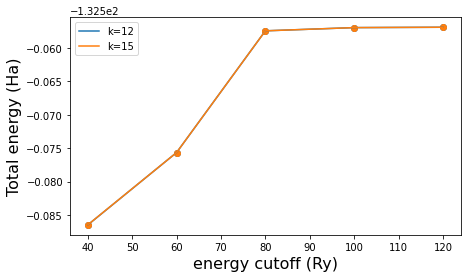

In [19]:
plt.figure(figsize=(7,4))
plt.xlabel('energy cutoff (Ry)',size=16)
plt.ylabel('Total energy (Ha)',size=16)
for k in kvalues:
    energy =study.fetch_results(id={'k':k},attribute='energy')
    print(k,energy)
    plt.plot(ecut,energy,label='k=%s'%k)
    plt.scatter(ecut,energy)
plt.legend()

12 [1.7907601771405592, 1.779899368613452, 1.7822396629370505, 1.782107054963031, 1.7820979470666745]
15 [1.7905564359098394, 1.7799468072022848, 1.7822836169279013, 1.7822497635577297, 1.7821721352079174]


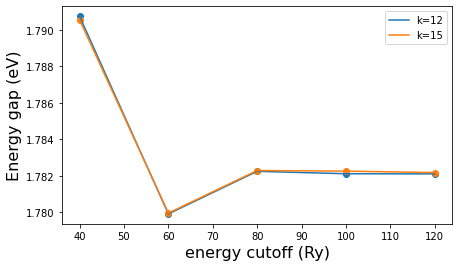

In [20]:
plt.figure(figsize=(7,4))
plt.xlabel('energy cutoff (Ry)',size=16)
plt.ylabel('Energy gap (eV)',size=16)
for k in kvalues:
    data = study.fetch_results(id={'k':k})    
    gap = [d.get_gap(verbose=False)['gap'] for d in data]
    print(k,gap)
    plt.plot(ecut,gap,label='k=%s'%k)
    plt.scatter(ecut,gap)
plt.legend()

12 [2.8366314290900174, 3.029014779004149, 3.0110235577398443, 3.010113660050341, 3.0100673561749383]
15 [2.8374166962313847, 3.029026197755989, 3.010997972857227, 3.010152923717392, 3.0099340122088796]


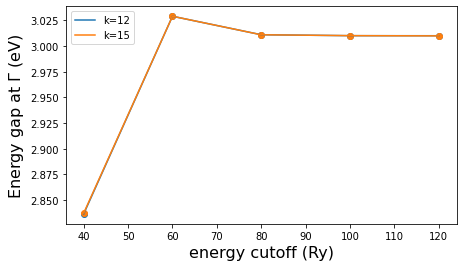

In [21]:
plt.figure(figsize=(7,4))
plt.xlabel('energy cutoff (Ry)',size=16)
plt.ylabel('Energy gap at $\Gamma$ (eV)',size=16)
for k in kvalues:
    data = study.fetch_results(id={'k':k})    
    gap_gamma = [d.get_evals()[0][26]- d.get_evals()[0][25] for d in data]
    print(k,gap_gamma)
    plt.plot(ecut,gap_gamma,label='k=%s'%k)
    plt.scatter(ecut,gap_gamma)
plt.legend()

On the basis of these results we choose

In [22]:
ecut_conv = 80 # energy cutoff on the wavefunction (Ry)
kpoints_conv = [12,12,1]

In [23]:
inp.set_energy_cutoff(ecut_conv)
inp.set_kpoints(type='automatic',points=kpoints_conv)

### Calculation of the equilibrium lattice constants and buckling parameter

We determine the equiblrium values of the lattice constant and of the buckling parameter by minimizing
the GS energy

In [24]:
alat_range = 2 # alat percentage variation
alat_num = 5 # number of calculations
delta_range = 2 # buckling percentage variation
delta_num = 5 # number of calculations

alat_span = np.linspace(-alat_range/2,alat_range/2,alat_num)

delta_span = np.linspace(-delta_range/2,delta_range/2,delta_num)

alat_span, delta_span

(array([-1. , -0.5,  0. ,  0.5,  1. ]), array([-1. , -0.5,  0. ,  0.5,  1. ]))

In [26]:
study = D.Dataset(run_dir=run_dir,num_tasks=10)

for a_span in alat_span:
    for d_span in delta_span:
        a = alat*(1+a_span/100)
        d = delta*(1+d_span/100)
        
        Mo_cart = np.array([0,1./np.sqrt(3.),0.])
        S1_cart = np.array([1./2.,1./(2*np.sqrt(3.)),d])
        S2_cart = np.array([1./2.,1./(2*np.sqrt(3.)),-d])
        idd = {'alat' : a_span, 'delta' : d_span}
        inp.set_prefix(D.name_from_id(idd))
        inp.set_atomic_positions([['Mo',Mo_cart],['S',S1_cart],['S',S2_cart]],type='alat')
        inp.set_lattice(ibrav=4,celldm1=a,celldm3=c/a)
        study.append_run(id=idd,input=inp,runner=code)
    
study.set_postprocessing_function(PP.pw_get_energy)
#study.set_postprocessing_function(PP.pw_parse_data)

Initialize a Dataset with 10 parallel tasks


In [27]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24] with the parallel task_groups [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [20, 21, 22, 23, 24]] 

Run the task [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
Skip the run of Skip the run ofalat_-1.0-delta_-1.0
 alat_-1.0-delta_-0.5Skip the run of
 alat_-1.0-delta_0.0
Skip the run of alat_-1.0-delta_0.5
Skip the run of alat_-1.0-delta_1.0
Skip the run of alat_-0.5-delta_-1.0
Skip the run of alat_-0.5-delta_-0.5Skip the run of
 alat_-0.5-delta_0.0
Skip the run of alat_-0.5-delta_0.5
Skip the run of alat_-0.5-delta_1.0
Task [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] ended 
 
Run the task [10, 11, 12, 13, 14, 15, 16, 17, 18, 19] 
Skip the run of Skip the run of
 alat_0.0-delta_-1.0alat_0.0-delta_-0.5Skip the run of
 alat_0.0-delta_0.0Skip the run of
 alat_0.0-delta_0.5
Skip the run of alat_0.0-delta_1.0Skip the run of
 alat_0.5-delta_-1.0
Skip the run of alat_0.5-delta_-0.5Skip 

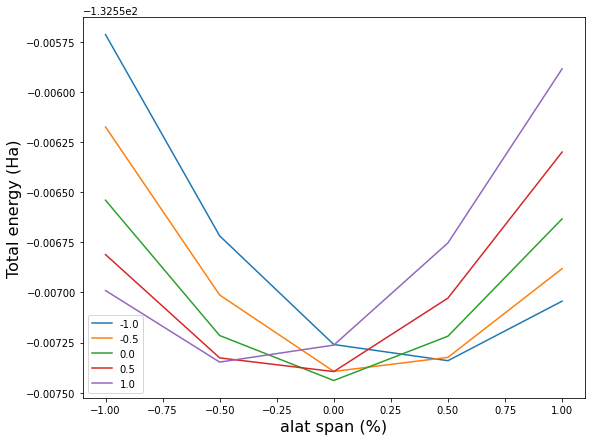

In [28]:
plt.figure(figsize=(9,7))
plt.xlabel('alat span (%)',size=16)
plt.ylabel('Total energy (Ha)',size=16)
for d_span in delta_span:
    energy =study.fetch_results(id={'delta':d_span})
    plt.plot(alat_span,energy,label=d_span)
plt.legend()

To find the optimal alat parameter we perform a quadratic fit of data (for delta=0)

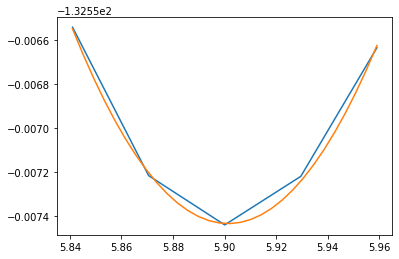

In [29]:
y =study.fetch_results(id={'delta':0.})
x = [alat*(1+a/100) for a in alat_span]
x_fit = np.linspace(x[0],x[-1],30)
coeffs = np.polyfit(x,y,2)
y_fit = [coeffs[0]*xx**2+coeffs[1]*xx+coeffs[2] for xx in x_fit]
plt.plot(x,y)
plt.plot(x_fit,y_fit)

In [30]:
x_eq = -coeffs[1]/(2*coeffs[0])
x_eq

5.901401607074741

In substantial agreement with the value already provided in the input.

In the same way the optimal buckling is 

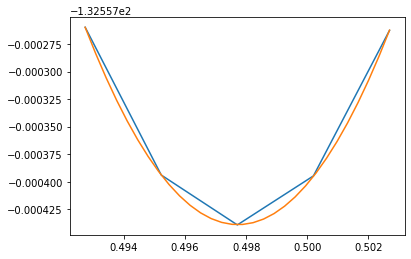

In [31]:
y =study.fetch_results(id={'alat':0.})
x = [delta*(1+a/100) for a in delta_span]
x_fit = np.linspace(x[0],x[-1],30)
coeffs = np.polyfit(x,y,2)
y_fit = [coeffs[0]*xx**2+coeffs[1]*xx+coeffs[2] for xx in x_fit]
plt.plot(x,y)
plt.plot(x_fit,y_fit)

In [49]:
x_eq = -coeffs[1]/(2*coeffs[0])
x_eq

0.497730467484591

### Converged ground states

Finally we perform a last scf calculation with converged parameters

In [4]:
run_dir = 'DFT_analysis'
pseudo_dir = '../pseudos'
Mo_pseudo = 'Mo-fr.out'
S_pseudo = 'S-fr.out'

alat_conv =  5.90140607 # in a.u. (Bohr)
delta_conv = 0.49773047 # in units of alat
c = 40.0 # vacuum distance in a.u. 

ecut_conv = 80 # energy cutoff on the wavefunction (Ry)
kpoints_conv = [12,12,1]

Mo_cart = np.array([0,1./np.sqrt(3.),0.])
S1_cart = np.array([1./2.,1./(2*np.sqrt(3.)),delta_conv])
S2_cart = np.array([1./2.,1./(2*np.sqrt(3.)),-delta_conv])

inp = I.PwInput()
inp.set_scf(force_symmorphic=True,conv_thr=1e-6)
inp.set_num_bnds(28)
inp.set_pseudo_dir(pseudo_dir=pseudo_dir)
inp.set_spinorbit()
inp.add_atom(atom='Mo',pseudo_name=Mo_pseudo,mass=42.00)
inp.add_atom(atom='S',pseudo_name=S_pseudo,mass=16.00)
inp.set_atoms_number(3)
inp.set_atomic_positions([['Mo',Mo_cart],['S',S1_cart],['S',S2_cart]],type='alat')
inp.set_lattice(ibrav=4,celldm1=alat_conv,celldm3=c/alat_conv)
inp.set_energy_cutoff(ecut_conv)
inp.set_kpoints(type='automatic',points=kpoints_conv)
inp

{'control': {'calculation': "'scf'",
  'verbosity': "'high'",
  'prefix': "'pwscf'",
  'outdir': "'./'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'nbnd': 28,
  'lspinorb': '.true.',
  'noncolin': '.true.',
  'ntyp': '2',
  'nat': '3',
  'ibrav': 4,
  'celldm(1)': 5.90140607,
  'celldm(3)': 6.7780456937781945,
  'ecutwfc': 80},
 'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
 'ions': {},
 'cell': {},
 'atomic_species': {'Mo': [42.0, 'Mo-fr.out'], 'S': [16.0, 'S-fr.out']},
 'atomic_positions': {'type': 'alat',
  'values': [['Mo', array([0.        , 0.57735027, 0.        ])],
   ['S', array([0.5       , 0.28867513, 0.49773047])],
   ['S', array([ 0.5       ,  0.28867513, -0.49773047])]]},
 'kpoints': {'type': 'automatic', 'values': ([12, 12, 1], [0.0, 0.0, 0.0])},
 'cell_parameters': {}}

In [5]:
study = D.Dataset(run_dir=run_dir,num_tasks=1)

idd = 'gs_converged'
inp.set_prefix(D.name_from_id(idd))
study.append_run(id=idd,input=inp,runner=code)
study.set_postprocessing_function(PP.pw_parse_data)

Initialize a Dataset with 1 parallel tasks


In [6]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
Skip the run of gs_converged
Task [0] ended 
 


In [7]:
results[0].get_gap()

Direct gap system
Gap : 1.7805438740579023 eV


{'gap': 1.7805438740579023,
 'direct_gap': 1.7805438740579023,
 'position_cbm': 18,
 'positon_vbm': 18,
 'positon_direct_gap': 18}

Gap at $\Gamma$

In [8]:
results[0].get_evals()[0][26]- results[0].get_evals()[0][25]

3.008639241620685

## Band structure on high symmetry line

Now we perform the bands computation specifying the kpoints on a path. 

To define the path we write the coordinates of the high symmetry points (using the tpiba_b type of
pw) and we make usage of the function build_kpath

In [14]:
bands_prefix = 'bands'
G = [0.,0.,0.]
Kp = [1./3.,1./np.sqrt(3),0.]
Mp = [0.,1./np.sqrt(3),0.]
high_sym = {'G':G,'K':Kp,'M':Mp} # useful to label the high-sym point on the path

In [15]:
klist = Tools.build_pw_kpath(G,Mp,Kp,G,numstep=60)
klist

[[0.0, 0.0, 0.0, 60],
 [0.0, 0.5773502691896258, 0.0, 60],
 [0.3333333333333333, 0.5773502691896258, 0.0, 60],
 [0.0, 0.0, 0.0, 0]]

In [16]:
inp.set_bands(30,force_symmorphic=True,conv_thr=1e-6)
inp.set_prefix(bands_prefix)
inp.set_kpoints(type='tpiba_b',klist=klist)
inp

{'control': {'calculation': "'bands'",
  'verbosity': "'high'",
  'prefix': "'bands'",
  'outdir': "'./'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'nbnd': 30,
  'lspinorb': '.true.',
  'noncolin': '.true.',
  'ntyp': '2',
  'nat': '3',
  'ibrav': 4,
  'celldm(1)': 5.90140607,
  'celldm(3)': 6.7780456937781945,
  'ecutwfc': 80},
 'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
 'ions': {},
 'cell': {},
 'atomic_species': {'Mo': [42.0, 'Mo-fr.out'], 'S': [16.0, 'S-fr.out']},
 'atomic_positions': {'type': 'alat',
  'values': [['Mo', array([0.        , 0.57735027, 0.        ])],
   ['S', array([0.5       , 0.28867513, 0.49773047])],
   ['S', array([ 0.5       ,  0.28867513, -0.49773047])]]},
 'kpoints': {'type': 'tpiba_b',
  'values': [[0.0, 0.0, 0.0, 60],
   [0.0, 0.5773502691896258, 0.0, 60],
   [0.3333333333333333, 0.5773502691896258, 0.0, 60],
   [0.0, 0.0, 0.0, 0]]},
 'cell_parameters': {}}

In [17]:
results = code.run(input=inp,run_dir=run_dir,name=bands_prefix,source_dir='DFT_analysis/gs_converged.save')

Skip the run of bands
The folder /work/dalessandro/TMDs/MoS2/DFT_analysis/bands.save already exists. Source_dir DFT_analysis/gs_converged.save not copied


Once that the computation is over we can create an instance of PwBands

In [18]:
bands = U.BandStructure.from_Pw(results,high_sym)

In [19]:
bands.get_high_sym_positions()

(['$\\Gamma$', '$\\Gamma$', 'K', 'M'],
 [0.0, 1.577350265701805, 0.9106835999999988, 0.57735027])

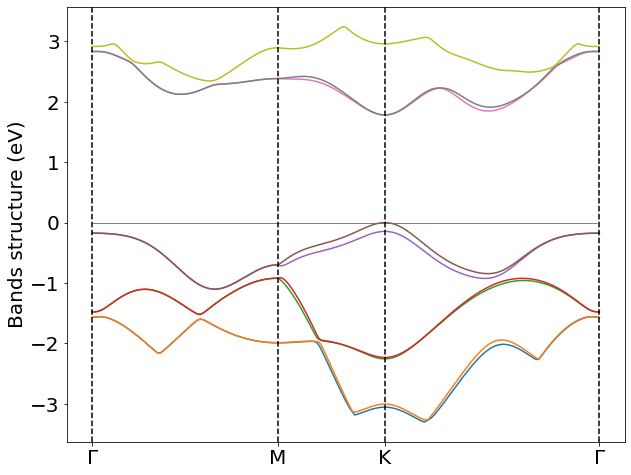

In [20]:
label_size = 20

fig, ax = plt.subplots(figsize=(10, 8))
#ax.set_ylim(-5,7)
bands.plot(plt,selection=[i for i in range(20,29)])
ax.hlines(0.,0.,1.57,linestyles='-',color='gray',linewidth=1)
ax.set_ylabel('Bands structure (eV)',size=label_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)

#plt.savefig(fname='Plot/band_structure.eps',format='eps',bbox_inches = "tight")

Compute the difference between the conduction energy at K and at the minimum value in the K valley

In [41]:
minind = argrelextrema(-bands.bands[26],np.greater,order=3)[0]
print(minind)
print(bands.kpath[minind])
bands.bands[26][minind[1]]-bands.bands[26][minind[2]]

[ 29 120 149]
[0.27905263 0.9106836  1.23290582]


-0.06615314174806586

## NSCF computations on regular grids

We set up the nscf computations on regular grids.

In agreement with the input provided by Fulvio Paleari we use  a 42x42x1 k-poinst sampling and 250 empty bands.

In [6]:
Gamma = np.array([0.,0.])
K = np.array([2./3.,0])
M = np.array([1./2.,1./(2*np.sqrt(3))])
Kp = np.array([1./3.,1./np.sqrt(3)])
Mp = np.array([0.,1./np.sqrt(3)])

In [7]:
nbnds = 400 #250
inp.set_nscf(nbnds,force_symmorphic=True,conv_thr=1e-6)
inp

{'control': {'calculation': "'nscf'",
  'verbosity': "'high'",
  'prefix': "'pwscf'",
  'outdir': "'./'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'nbnd': 400,
  'lspinorb': '.true.',
  'noncolin': '.true.',
  'ntyp': '2',
  'nat': '3',
  'ibrav': 4,
  'celldm(1)': 5.90140607,
  'celldm(3)': 6.7780456937781945,
  'ecutwfc': 80},
 'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
 'ions': {},
 'cell': {},
 'atomic_species': {'Mo': [42.0, 'Mo-fr.out'], 'S': [16.0, 'S-fr.out']},
 'atomic_positions': {'type': 'alat',
  'values': [['Mo', array([0.        , 0.57735027, 0.        ])],
   ['S', array([0.5       , 0.28867513, 0.49773047])],
   ['S', array([ 0.5       ,  0.28867513, -0.49773047])]]},
 'kpoints': {'type': 'automatic', 'values': ([12, 12, 1], [0.0, 0.0, 0.0])},
 'cell_parameters': {}}

In [8]:
kvalues = [30] #[18,30,42]

In [9]:
study = D.Dataset(run_dir=run_dir,num_tasks=1)
study.set_postprocessing_function(PP.pw_parse_data)

for k in kvalues:
    idd = {'kpoints':k,'nbnds':nbnds}
    inp.set_prefix(D.name_from_id(idd))
    inp.set_kpoints(points=[k,k,1])
    study.append_run(id=idd,input=inp,runner=code,source_dir='DFT_analysis/gs_converged.save')

Initialize a Dataset with 1 parallel tasks


In [10]:
study.runs[0]

{'label': 'Dataset',
 'run_dir': 'DFT_analysis',
 'num_tasks': 1,
 'verbose': True,
 'input': {'control': {'calculation': "'nscf'",
   'verbosity': "'high'",
   'prefix': "'kpoints_30-nbnds_400'",
   'outdir': "'./'",
   'pseudo_dir': "'../pseudos'"},
  'system': {'force_symmorphic': '.true.',
   'nbnd': 400,
   'lspinorb': '.true.',
   'noncolin': '.true.',
   'ntyp': '2',
   'nat': '3',
   'ibrav': 4,
   'celldm(1)': 5.90140607,
   'celldm(3)': 6.7780456937781945,
   'ecutwfc': 80},
  'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
  'ions': {},
  'cell': {},
  'atomic_species': {'Mo': [42.0, 'Mo-fr.out'], 'S': [16.0, 'S-fr.out']},
  'atomic_positions': {'type': 'alat',
   'values': [['Mo', array([0.        , 0.57735027, 0.        ])],
    ['S', array([0.5       , 0.28867513, 0.49773047])],
    ['S', array([ 0.5       ,  0.28867513, -0.49773047])]]},
  'kpoints': {'type': 'automatic', 'values': ([30, 30, 1], [0.0, 0.0, 0.0])},
  'cell_parameters': {}},
 'source_dir': '

In [11]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
copy source_dir DFT_analysis/gs_converged.save in the /work/dalessandro/TMDs/MoS2/DFT_analysis/kpoints_30-nbnds_400.save
run command: mpirun -np 16 pw.x -inp kpoints_30-nbnds_400.in > kpoints_30-nbnds_400.log
slurm submit:  cd DFT_analysis ; sbatch job_kpoints_30-nbnds_400.sh
computation kpoints_30-nbnds_400 is running...
computation kpoints_30-nbnds_400 ended
Task [0] ended 
 


In [15]:
kp = results[2].kpoints # cartesian coordinates in units of 2\pi/alat

number of kpoints = 169


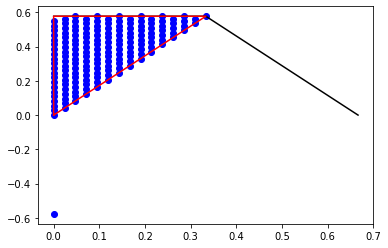

In [16]:
BZ = [K, Kp, Mp]
print('number of kpoints = %s'%len(kp))
plt.plot(*np.column_stack(BZ),color='black')
IBZ = [Gamma,Kp, Mp,Gamma]
plt.plot(*np.column_stack(IBZ),color='red')
plt.scatter(kp[:,0],kp[:,1],c='blue')

## Analysis of bands character in terms of the lattice constant

We study the band structure in function of the lattice constant. Indeed the (DFT) nature of the
gap depends on the atomic distance and starting with a properly chose value can provide direct
band semiconductor also at the GW level.

In this analysis we modify only the alat parameter

In [42]:
run_dir = 'DFT_analysis'
pseudo_dir = '../pseudos'
Mo_pseudo = 'Mo-fr.out'
S_pseudo = 'S-fr.out'

#alat_conv =  5.90140607 # in a.u. (Bohr)
delta_conv = 0.49773047 # in units of alat
c = 40.0 # vacuum distance in a.u. 

ecut_conv = 80 # energy cutoff on the wavefunction (Ry)
kpoints_conv = [12,12,1]

Mo_cart = np.array([0,1./np.sqrt(3.),0.])
S1_cart = np.array([1./2.,1./(2*np.sqrt(3.)),delta_conv])
S2_cart = np.array([1./2.,1./(2*np.sqrt(3.)),-delta_conv])

inp = I.PwInput()
inp.set_scf(force_symmorphic=True,conv_thr=1e-6)
inp.set_num_bnds(28)
inp.set_pseudo_dir(pseudo_dir=pseudo_dir)
inp.set_spinorbit()
inp.add_atom(atom='Mo',pseudo_name=Mo_pseudo,mass=42.00)
inp.add_atom(atom='S',pseudo_name=S_pseudo,mass=16.00)
inp.set_atoms_number(3)
inp.set_atomic_positions([['Mo',Mo_cart],['S',S1_cart],['S',S2_cart]],type='alat')
#inp.set_lattice(ibrav=4,celldm1=alat_conv,celldm3=c/alat_conv)
inp.set_energy_cutoff(ecut_conv)
inp.set_kpoints(type='automatic',points=kpoints_conv)
inp

{'control': {'calculation': "'scf'",
  'verbosity': "'high'",
  'prefix': "'pwscf'",
  'outdir': "'./'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'nbnd': 28,
  'lspinorb': '.true.',
  'noncolin': '.true.',
  'ntyp': '2',
  'nat': '3',
  'ecutwfc': 80},
 'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
 'ions': {},
 'cell': {},
 'atomic_species': {'Mo': [42.0, 'Mo-fr.out'], 'S': [16.0, 'S-fr.out']},
 'atomic_positions': {'type': 'alat',
  'values': [['Mo', array([0.        , 0.57735027, 0.        ])],
   ['S', array([0.5       , 0.28867513, 0.49773047])],
   ['S', array([ 0.5       ,  0.28867513, -0.49773047])]]},
 'kpoints': {'type': 'automatic', 'values': ([12, 12, 1], [0.0, 0.0, 0.0])},
 'cell_parameters': {}}

In [43]:
alat_values = [3.0,3.1,3.2] # Angstrom

study = D.Dataset(run_dir=run_dir,num_tasks=3)
study.set_postprocessing_function(PP.pw_parse_data)

for a_ang in alat_values:
    a = a_ang/U.Constants.Bohr_to_Angstrom
    inp.set_lattice(ibrav=4,celldm1=a,celldm3=c/a)
    idd = 'gs-alat_%s'%a_ang
    inp.set_prefix(D.name_from_id(idd))
    study.append_run(id=idd,input=inp,runner=code)

Initialize a Dataset with 3 parallel tasks


In [44]:
#study.runs[0]

In [45]:
results = study.run()

Run the selection [0, 1, 2] with the parallel task_groups [[0, 1, 2]] 

Run the task [0, 1, 2] 
Skip the run of Skip the run ofgs-alat_3.0
 gs-alat_3.1
Skip the run of gs-alat_3.2
Task [0, 1, 2] ended 
 


In [46]:
results[2].get_gap()

Direct gap system
Gap : 1.5989475902408479 eV


{'gap': 1.5989475902408479,
 'direct_gap': 1.5989475902408479,
 'position_cbm': 18,
 'positon_vbm': 18,
 'positon_direct_gap': 18}

In [47]:
for ind in range(len(results)):
    print(results[ind].get_gap())

Indirect gap system
Gap : 2.097926070549967 eV
Direct gap : 2.110643281079845 eV
{'gap': 2.097926070549967, 'direct_gap': 2.110643281079845, 'position_cbm': 12, 'positon_vbm': 18, 'positon_direct_gap': 18}
Direct gap system
Gap : 1.8380070208326544 eV
{'gap': 1.8380070208326544, 'direct_gap': 1.8380070208326544, 'position_cbm': 18, 'positon_vbm': 18, 'positon_direct_gap': 18}
Direct gap system
Gap : 1.5989475902408479 eV
{'gap': 1.5989475902408479, 'direct_gap': 1.5989475902408479, 'position_cbm': 18, 'positon_vbm': 18, 'positon_direct_gap': 18}


Now we perform the bands computation specifying the kpoints on a path

In [48]:
G = [0.,0.,0.]
Kp = [1./3.,1./np.sqrt(3),0.]
Mp = [0.,1./np.sqrt(3),0.]
high_sym = {'G':G,'K':Kp,'M':Mp} # useful to label the high-sym point on the path

In [49]:
klist = Tools.build_pw_kpath(G,Mp,Kp,G,numstep=60)
klist

[[0.0, 0.0, 0.0, 60],
 [0.0, 0.5773502691896258, 0.0, 60],
 [0.3333333333333333, 0.5773502691896258, 0.0, 60],
 [0.0, 0.0, 0.0, 0]]

In [50]:
inp.set_bands(30,force_symmorphic=True,conv_thr=1e-6)
inp.set_kpoints(type='tpiba_b',klist=klist)

study = D.Dataset(run_dir=run_dir,num_tasks=2)

for a_ang in alat_values:
    a = a_ang/U.Constants.Bohr_to_Angstrom
    inp.set_lattice(ibrav=4,celldm1=a,celldm3=c/a)
    idd = 'bands-alat_%s'%a_ang
    inp.set_prefix(D.name_from_id(idd))
    study.append_run(id=idd,input=inp,runner=code,source_dir='DFT_analysis/gs-alat_%s.save'%a_ang)

Initialize a Dataset with 2 parallel tasks


In [51]:
#study.runs[0]

In [52]:
results = study.run()

Run the selection [0, 1, 2] with the parallel task_groups [[0, 1], [2]] 

Run the task [0, 1] 
Skip the run of bands-alat_3.0
Skip the run of bands-alat_3.1
The folder /work/dalessandro/TMDs/MoS2/DFT_analysis/bands-alat_3.1.save already exists. Source_dir DFT_analysis/gs-alat_3.1.save not copiedThe folder /work/dalessandro/TMDs/MoS2/DFT_analysis/bands-alat_3.0.save already exists. Source_dir DFT_analysis/gs-alat_3.0.save not copied

Task [0, 1] ended 
 
Run the task [2] 
Skip the run of bands-alat_3.2
The folder /work/dalessandro/TMDs/MoS2/DFT_analysis/bands-alat_3.2.save already exists. Source_dir DFT_analysis/gs-alat_3.2.save not copied
Task [2] ended 
 


In [53]:
results

{0: '/work/dalessandro/TMDs/MoS2/DFT_analysis/bands-alat_3.0.save/data-file-schema.xml',
 1: '/work/dalessandro/TMDs/MoS2/DFT_analysis/bands-alat_3.1.save/data-file-schema.xml',
 2: '/work/dalessandro/TMDs/MoS2/DFT_analysis/bands-alat_3.2.save/data-file-schema.xml'}

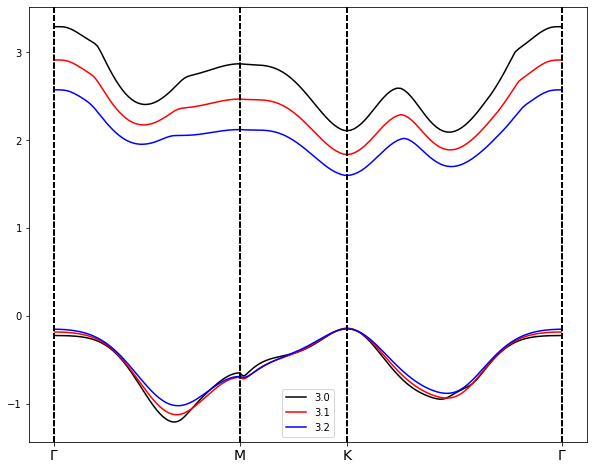

In [55]:
label_size = 20
fig, ax = plt.subplots(figsize=(10, 8))
colors = {3.0:'black', 3.1:'red', 3.2:'blue'}

for ind,a in enumerate(alat_values):
    bands = U.BandStructure.from_Pw(results[ind],high_sym)
    bands.plot(plt,selection=[24],c=colors[a],label=a)
    bands.plot(plt,selection=[26],c=colors[a])
plt.legend()
    

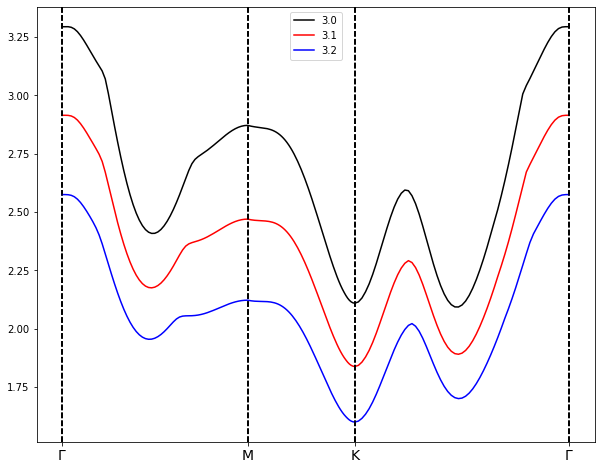

In [56]:
label_size = 20
fig, ax = plt.subplots(figsize=(10, 8))
colors = {3.0:'black', 3.1:'red', 3.2:'blue'}

for ind,a in enumerate(alat_values):
    bands = U.BandStructure.from_Pw(results[ind],high_sym)
    bands.plot(plt,selection=[26],c=colors[a],label=a)
plt.legend()

We observe that tensile strain reduced the gap and increase the energy of the mininum in the K valley w.r.t. the
conduction minumum. 

Compute the difference between the conduction energy at K and at the minimum value in the K valley

In [59]:
ind = 2
bands = U.BandStructure.from_Pw(results[ind],high_sym)

minind = argrelextrema(-bands.bands[26],np.greater,order=3)[0]
print(minind)
print(bands.kpath[minind])
bands.bands[26][minind[1]]-bands.bands[26][minind[2]]

[ 28 120 149]
[0.26943013 0.9106836  1.23290582]


-0.10039231607242316

## NSCF computation on regular grid for alat=3.2

We set up the nscf computations on a 30x30x1 regualr grid with 250 bands.

In [13]:
name = 'kpoints_30-nbnds_250-alat_3.2'
run_dir = 'DFT_analysis'
pseudo_dir = '../pseudos'
Mo_pseudo = 'Mo-fr.out'
S_pseudo = 'S-fr.out'
alat_ang =  3.2 # in Angstrom
nbnds = 250
delta_conv = 0.49773047 # in units of alat
c = 40.0 # vacuum distance in a.u. 
ecut_conv = 80 # energy cutoff on the wavefunction (Ry)
kpoints = [30,30,1]

alat = alat_ang/U.Constants.Bohr_to_Angstrom

Mo_cart = np.array([0,1./np.sqrt(3.),0.])
S1_cart = np.array([1./2.,1./(2*np.sqrt(3.)),delta_conv])
S2_cart = np.array([1./2.,1./(2*np.sqrt(3.)),-delta_conv])

inp = I.PwInput()
inp.set_nscf(nbnds,force_symmorphic=True,conv_thr=1e-6)
inp.set_prefix(name)
inp.set_pseudo_dir(pseudo_dir=pseudo_dir)
inp.set_spinorbit()
inp.add_atom(atom='Mo',pseudo_name=Mo_pseudo,mass=42.00)
inp.add_atom(atom='S',pseudo_name=S_pseudo,mass=16.00)
inp.set_atoms_number(3)
inp.set_atomic_positions([['Mo',Mo_cart],['S',S1_cart],['S',S2_cart]],type='alat')
inp.set_lattice(ibrav=4,celldm1=alat,celldm3=c/alat)
inp.set_energy_cutoff(ecut_conv)
inp.set_kpoints(type='automatic',points=kpoints)
inp

{'control': {'calculation': "'nscf'",
  'verbosity': "'high'",
  'prefix': "'kpoints_30-nbnds_250-alat_3.2'",
  'outdir': "'./'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'nbnd': 250,
  'lspinorb': '.true.',
  'noncolin': '.true.',
  'ntyp': '2',
  'nat': '3',
  'ibrav': 4,
  'celldm(1)': 6.047123163452555,
  'celldm(3)': 6.6147156124999995,
  'ecutwfc': 80},
 'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
 'ions': {},
 'cell': {},
 'atomic_species': {'Mo': [42.0, 'Mo-fr.out'], 'S': [16.0, 'S-fr.out']},
 'atomic_positions': {'type': 'alat',
  'values': [['Mo', array([0.        , 0.57735027, 0.        ])],
   ['S', array([0.5       , 0.28867513, 0.49773047])],
   ['S', array([ 0.5       ,  0.28867513, -0.49773047])]]},
 'kpoints': {'type': 'automatic', 'values': ([30, 30, 1], [0.0, 0.0, 0.0])},
 'cell_parameters': {}}

In [14]:
results = code.run(input=inp,run_dir=run_dir,name=name,source_dir='DFT_analysis/gs-alat_3.2.save')

delete job_out script: DFT_analysis/job_kpoints_30-nbnds_250-alat_3.2.out
delete log file: DFT_analysis/kpoints_30-nbnds_250-alat_3.2.log
delete folder: /work/dalessandro/TMDs/MoS2/DFT_analysis/kpoints_30-nbnds_250-alat_3.2.save
copy source_dir DFT_analysis/gs-alat_3.2.save in the /work/dalessandro/TMDs/MoS2/DFT_analysis/kpoints_30-nbnds_250-alat_3.2.save
run command: mpirun -np 16 pw.x -inp kpoints_30-nbnds_250-alat_3.2.in > kpoints_30-nbnds_250-alat_3.2.log
slurm submit:  cd DFT_analysis ; sbatch job_kpoints_30-nbnds_250-alat_3.2.sh
computation kpoints_30-nbnds_250-alat_3.2 is running...
computation kpoints_30-nbnds_250-alat_3.2 ended


## Analysis with SG15 pseudopotential

We compute the band structure using the parameters derived in the convergence procedure performed above but with the pseudos of the SG15 database

In [6]:
pseudo_dir = '../pseudos'
Mo_pseudo = 'Mo_ONCV_PBE-1.2.upf'
S_pseudo = 'S_ONCV_PBE-1.2.upf'
run_dir = 'DFT_analysis'

alat_conv =  5.90140607 # in a.u. (Bohr)
delta_conv = 0.49773047 # in units of alat
c = 40.0 # vacuum distance in a.u. 

ecut_conv = 80 # energy cutoff on the wavefunction (Ry)
kpoints_conv = [12,12,1]

Mo_cart = np.array([0,1./np.sqrt(3.),0.])
S1_cart = np.array([1./2.,1./(2*np.sqrt(3.)),delta_conv])
S2_cart = np.array([1./2.,1./(2*np.sqrt(3.)),-delta_conv])

inp = I.PwInput()
inp.set_scf(force_symmorphic=True,conv_thr=1e-6)
inp.set_num_bnds(28)
inp.set_pseudo_dir(pseudo_dir=pseudo_dir)
inp.set_spinorbit()
inp.add_atom(atom='Mo',pseudo_name=Mo_pseudo,mass=42.00)
inp.add_atom(atom='S',pseudo_name=S_pseudo,mass=16.00)
inp.set_atoms_number(3)
inp.set_atomic_positions([['Mo',Mo_cart],['S',S1_cart],['S',S2_cart]],type='alat')
inp.set_lattice(ibrav=4,celldm1=alat_conv,celldm3=c/alat_conv)
inp.set_energy_cutoff(ecut_conv)
inp.set_kpoints(type='automatic',points=kpoints_conv)
inp

{'control': {'calculation': "'scf'",
  'verbosity': "'high'",
  'prefix': "'pwscf'",
  'outdir': "'./'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'nbnd': 28,
  'lspinorb': '.true.',
  'noncolin': '.true.',
  'ntyp': '2',
  'nat': '3',
  'ibrav': 4,
  'celldm(1)': 5.90140607,
  'celldm(3)': 6.7780456937781945,
  'ecutwfc': 80},
 'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
 'ions': {},
 'cell': {},
 'atomic_species': {'Mo': [42.0, 'Mo_ONCV_PBE-1.2.upf'],
  'S': [16.0, 'S_ONCV_PBE-1.2.upf']},
 'atomic_positions': {'type': 'alat',
  'values': [['Mo', array([0.        , 0.57735027, 0.        ])],
   ['S', array([0.5       , 0.28867513, 0.49773047])],
   ['S', array([ 0.5       ,  0.28867513, -0.49773047])]]},
 'kpoints': {'type': 'automatic', 'values': ([12, 12, 1], [0.0, 0.0, 0.0])},
 'cell_parameters': {}}

In [7]:
study = D.Dataset(run_dir=run_dir,num_tasks=1)

idd = 'gs_converged-sg15'
inp.set_prefix(D.name_from_id(idd))
study.append_run(id=idd,input=inp,runner=code)
study.set_postprocessing_function(PP.pw_parse_data)

Initialize a Dataset with 1 parallel tasks


In [8]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
run command: mpirun -np 16 pw.x -inp gs_converged-sg15.in > gs_converged-sg15.log
slurm submit:  cd DFT_analysis ; sbatch job_gs_converged-sg15.sh
computation gs_converged-sg15 is running...
computation gs_converged-sg15 ended
Task [0] ended 
 


In [9]:
results[0].get_gap()

Direct gap system
Gap : 1.864556322901123 eV


{'gap': 1.864556322901123,
 'direct_gap': 1.864556322901123,
 'position_cbm': 18,
 'position_vbm': 18,
 'position_direct_gap': 18}

### Band structure on high symmetry line

Now we perform the bands computation specifying the kpoints on a path. 

To define the path we write the coordinates of the high symmetry points (using the tpiba_b type of
pw) and we make usage of the function build_kpath

In [15]:
bands_prefix = 'bands-sg15'
G = [0.,0.,0.]
Kp = [1./3.,1./np.sqrt(3),0.]
Mp = [0.,1./np.sqrt(3),0.]
high_sym = {'G':G,'K':Kp,'M':Mp} # useful to label the high-sym point on the path

In [16]:
klist = Tools.build_pw_kpath(G,Mp,Kp,G,numstep=40)
klist

[[0.0, 0.0, 0.0, 40],
 [0.0, 0.5773502691896258, 0.0, 40],
 [0.3333333333333333, 0.5773502691896258, 0.0, 40],
 [0.0, 0.0, 0.0, 0]]

In [17]:
inp.set_bands(30,force_symmorphic=True,conv_thr=1e-6)
inp.set_prefix(bands_prefix)
inp.set_kpoints(type='tpiba_b',klist=klist)
inp

{'control': {'calculation': "'bands'",
  'verbosity': "'high'",
  'prefix': "'bands-sg15'",
  'outdir': "'./'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'nbnd': 30,
  'lspinorb': '.true.',
  'noncolin': '.true.',
  'ntyp': '2',
  'nat': '3',
  'ibrav': 4,
  'celldm(1)': 5.90140607,
  'celldm(3)': 6.7780456937781945,
  'ecutwfc': 80},
 'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
 'ions': {},
 'cell': {},
 'atomic_species': {'Mo': [42.0, 'Mo_ONCV_PBE-1.2.upf'],
  'S': [16.0, 'S_ONCV_PBE-1.2.upf']},
 'atomic_positions': {'type': 'alat',
  'values': [['Mo', array([0.        , 0.57735027, 0.        ])],
   ['S', array([0.5       , 0.28867513, 0.49773047])],
   ['S', array([ 0.5       ,  0.28867513, -0.49773047])]]},
 'kpoints': {'type': 'tpiba_b',
  'values': [[0.0, 0.0, 0.0, 40],
   [0.0, 0.5773502691896258, 0.0, 40],
   [0.3333333333333333, 0.5773502691896258, 0.0, 40],
   [0.0, 0.0, 0.0, 0]]},
 'cell_parameters': {}}

In [18]:
results = code.run(input=inp,run_dir=run_dir,name=bands_prefix,source_dir='DFT_analysis/gs_converged-sg15.save')

copy source_dir DFT_analysis/gs_converged-sg15.save in the /work/dalessandro/TMDs/MoS2/DFT_analysis/bands-sg15.save
run command: mpirun -np 16 pw.x -inp bands-sg15.in > bands-sg15.log
slurm submit:  cd DFT_analysis ; sbatch job_bands-sg15.sh
computation bands-sg15 is running...
computation bands-sg15 ended


Once that the computation is over we can create an instance of PwBands

In [19]:
bands = U.BandStructure.from_Pw(results,high_sym)

In [20]:
bands.get_high_sym_positions()

(['$\\Gamma$', '$\\Gamma$', 'K', 'M'],
 [0.0, 1.5773502657018035, 0.9106835999999987, 0.57735027])

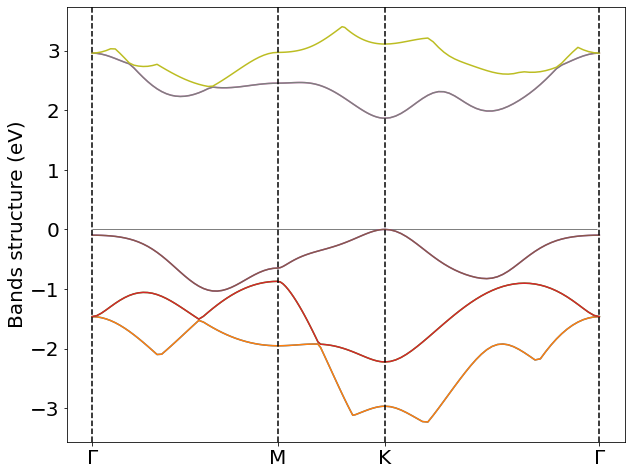

In [21]:
label_size = 20

fig, ax = plt.subplots(figsize=(10, 8))
#ax.set_ylim(-5,7)
bands.plot(plt,selection=[i for i in range(20,29)])
ax.hlines(0.,0.,1.57,linestyles='-',color='gray',linewidth=1)
ax.set_ylabel('Bands structure (eV)',size=label_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)

#plt.savefig(fname='Plot/band_structure.eps',format='eps',bbox_inches = "tight")

Compute the difference between the conduction energy at K and at the minimum value in the K valley

In [22]:
minind = argrelextrema(-bands.bands[26],np.greater,order=3)[0]
print(minind)
print(bands.kpath[minind])
bands.bands[26][minind[1]]-bands.bands[26][minind[2]]

[19 80 99]
[0.27424138 0.9106836  1.22735027]


-0.12144182867440034

## Analysis with SG15 pseudopotential (Full relativistic)

We compute the band structure using the parameters derived in the convergence procedure performed above but with the pseudos of the SG15 database

In [25]:
pseudo_dir = '../pseudos'
Mo_pseudo = 'Mo_ONCV_PBE_FR-1.0.upf'
S_pseudo = 'S_ONCV_PBE_FR-1.1.upf'
run_dir = 'DFT_analysis'

alat_conv =  5.90140607 # in a.u. (Bohr)
delta_conv = 0.49773047 # in units of alat
c = 40.0 # vacuum distance in a.u. 

ecut_conv = 80 # energy cutoff on the wavefunction (Ry)
kpoints_conv = [12,12,1]

Mo_cart = np.array([0,1./np.sqrt(3.),0.])
S1_cart = np.array([1./2.,1./(2*np.sqrt(3.)),delta_conv])
S2_cart = np.array([1./2.,1./(2*np.sqrt(3.)),-delta_conv])

inp = I.PwInput()
inp.set_scf(force_symmorphic=True,conv_thr=1e-6)
inp.set_num_bnds(28)
inp.set_pseudo_dir(pseudo_dir=pseudo_dir)
inp.set_spinorbit()
inp.add_atom(atom='Mo',pseudo_name=Mo_pseudo,mass=42.00)
inp.add_atom(atom='S',pseudo_name=S_pseudo,mass=16.00)
inp.set_atoms_number(3)
inp.set_atomic_positions([['Mo',Mo_cart],['S',S1_cart],['S',S2_cart]],type='alat')
inp.set_lattice(ibrav=4,celldm1=alat_conv,celldm3=c/alat_conv)
inp.set_energy_cutoff(ecut_conv)
inp.set_kpoints(type='automatic',points=kpoints_conv)
inp

{'control': {'calculation': "'scf'",
  'verbosity': "'high'",
  'prefix': "'pwscf'",
  'outdir': "'./'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'nbnd': 28,
  'lspinorb': '.true.',
  'noncolin': '.true.',
  'ntyp': '2',
  'nat': '3',
  'ibrav': 4,
  'celldm(1)': 5.90140607,
  'celldm(3)': 6.7780456937781945,
  'ecutwfc': 80},
 'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
 'ions': {},
 'cell': {},
 'atomic_species': {'Mo': [42.0, 'Mo_ONCV_PBE_FR-1.0.upf'],
  'S': [16.0, 'S_ONCV_PBE_FR-1.1.upf']},
 'atomic_positions': {'type': 'alat',
  'values': [['Mo', array([0.        , 0.57735027, 0.        ])],
   ['S', array([0.5       , 0.28867513, 0.49773047])],
   ['S', array([ 0.5       ,  0.28867513, -0.49773047])]]},
 'kpoints': {'type': 'automatic', 'values': ([12, 12, 1], [0.0, 0.0, 0.0])},
 'cell_parameters': {}}

In [26]:
study = D.Dataset(run_dir=run_dir,num_tasks=1)

idd = 'gs_converged-sg15_FR'
inp.set_prefix(D.name_from_id(idd))
study.append_run(id=idd,input=inp,runner=code)
study.set_postprocessing_function(PP.pw_parse_data)

Initialize a Dataset with 1 parallel tasks


In [27]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
run command: mpirun -np 16 pw.x -inp gs_converged-sg15_FR.in > gs_converged-sg15_FR.log
slurm submit:  cd DFT_analysis ; sbatch job_gs_converged-sg15_FR.sh
computation gs_converged-sg15_FR is running...
computation gs_converged-sg15_FR ended
Task [0] ended 
 


In [28]:
results[0].get_gap()

Direct gap system
Gap : 1.7876696485308337 eV


{'gap': 1.7876696485308337,
 'direct_gap': 1.7876696485308337,
 'position_cbm': 18,
 'position_vbm': 18,
 'position_direct_gap': 18}

### Band structure on high symmetry line

Now we perform the bands computation specifying the kpoints on a path. 

To define the path we write the coordinates of the high symmetry points (using the tpiba_b type of
pw) and we make usage of the function build_kpath

In [29]:
bands_prefix = 'bands-sg15_FR'
G = [0.,0.,0.]
Kp = [1./3.,1./np.sqrt(3),0.]
Mp = [0.,1./np.sqrt(3),0.]
high_sym = {'G':G,'K':Kp,'M':Mp} # useful to label the high-sym point on the path

In [30]:
klist = Tools.build_pw_kpath(G,Mp,Kp,G,numstep=40)
klist

[[0.0, 0.0, 0.0, 40],
 [0.0, 0.5773502691896258, 0.0, 40],
 [0.3333333333333333, 0.5773502691896258, 0.0, 40],
 [0.0, 0.0, 0.0, 0]]

In [31]:
inp.set_bands(30,force_symmorphic=True,conv_thr=1e-6)
inp.set_prefix(bands_prefix)
inp.set_kpoints(type='tpiba_b',klist=klist)
inp

{'control': {'calculation': "'bands'",
  'verbosity': "'high'",
  'prefix': "'bands-sg15_FR'",
  'outdir': "'./'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'nbnd': 30,
  'lspinorb': '.true.',
  'noncolin': '.true.',
  'ntyp': '2',
  'nat': '3',
  'ibrav': 4,
  'celldm(1)': 5.90140607,
  'celldm(3)': 6.7780456937781945,
  'ecutwfc': 80},
 'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
 'ions': {},
 'cell': {},
 'atomic_species': {'Mo': [42.0, 'Mo_ONCV_PBE_FR-1.0.upf'],
  'S': [16.0, 'S_ONCV_PBE_FR-1.1.upf']},
 'atomic_positions': {'type': 'alat',
  'values': [['Mo', array([0.        , 0.57735027, 0.        ])],
   ['S', array([0.5       , 0.28867513, 0.49773047])],
   ['S', array([ 0.5       ,  0.28867513, -0.49773047])]]},
 'kpoints': {'type': 'tpiba_b',
  'values': [[0.0, 0.0, 0.0, 40],
   [0.0, 0.5773502691896258, 0.0, 40],
   [0.3333333333333333, 0.5773502691896258, 0.0, 40],
   [0.0, 0.0, 0.0, 0]]},
 'cell_parameters': {}}

In [32]:
results = code.run(input=inp,run_dir=run_dir,name=bands_prefix,source_dir='DFT_analysis/gs_converged-sg15_FR.save')

copy source_dir DFT_analysis/gs_converged-sg15_FR.save in the /work/dalessandro/TMDs/MoS2/DFT_analysis/bands-sg15_FR.save
run command: mpirun -np 16 pw.x -inp bands-sg15_FR.in > bands-sg15_FR.log
slurm submit:  cd DFT_analysis ; sbatch job_bands-sg15_FR.sh
computation bands-sg15_FR is running...
computation bands-sg15_FR ended


Once that the computation is over we can create an instance of PwBands

In [33]:
bands = U.BandStructure.from_Pw(results,high_sym)

In [34]:
bands.get_high_sym_positions()

(['$\\Gamma$', '$\\Gamma$', 'K', 'M'],
 [0.0, 1.5773502657018035, 0.9106835999999987, 0.57735027])

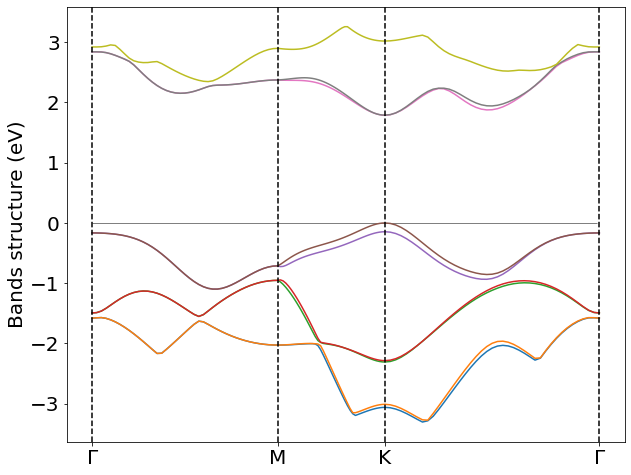

In [35]:
label_size = 20

fig, ax = plt.subplots(figsize=(10, 8))
#ax.set_ylim(-5,7)
bands.plot(plt,selection=[i for i in range(20,29)])
ax.hlines(0.,0.,1.57,linestyles='-',color='gray',linewidth=1)
ax.set_ylabel('Bands structure (eV)',size=label_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)

#plt.savefig(fname='Plot/band_structure.eps',format='eps',bbox_inches = "tight")

Compute the difference between the conduction energy at K and at the minimum value in the K valley

In [36]:
minind = argrelextrema(-bands.bands[26],np.greater,order=3)[0]
print(minind)
print(bands.kpath[minind])
bands.bands[26][minind[1]]-bands.bands[26][minind[2]]

[19 80 99]
[0.27424138 0.9106836  1.22735027]


-0.0896598307069707

## Convergence analysis with SG15 pseudopotential (Full relativistic)

We perform the convergence procedure with the SG15 pseudo to find the equilibrium lattice parameters and compute the band structure.

In [6]:
pseudo_dir = '../pseudos'
Mo_pseudo = 'Mo_ONCV_PBE_FR-1.0.upf'
S_pseudo = 'S_ONCV_PBE_FR-1.1.upf'
run_dir = 'DFT_analysis-sg15'

alat =  5.90140607 # in a.u. (Bohr)
delta = 0.49773047 # in units of alat
c = 40.0 # vacuum distance in a.u. 

ecut = 80 # energy cutoff on the wavefunction (Ry)
kpoints = [12,12,1]

Mo_cart = np.array([0,1./np.sqrt(3.),0.])
S1_cart = np.array([1./2.,1./(2*np.sqrt(3.)),delta])
S2_cart = np.array([1./2.,1./(2*np.sqrt(3.)),-delta])

inp = I.PwInput()
inp.set_scf(force_symmorphic=True,conv_thr=1e-6)
inp.set_num_bnds(28)
inp.set_pseudo_dir(pseudo_dir=pseudo_dir)
inp.set_spinorbit()
inp.add_atom(atom='Mo',pseudo_name=Mo_pseudo,mass=42.00)
inp.add_atom(atom='S',pseudo_name=S_pseudo,mass=16.00)
inp.set_atoms_number(3)
inp.set_atomic_positions([['Mo',Mo_cart],['S',S1_cart],['S',S2_cart]],type='alat')
inp.set_lattice(ibrav=4,celldm1=alat,celldm3=c/alat)
inp.set_energy_cutoff(ecut)
inp.set_kpoints(type='automatic',points=kpoints)
inp

{'control': {'calculation': "'scf'",
  'verbosity': "'high'",
  'prefix': "'pwscf'",
  'outdir': "'./'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'nbnd': 28,
  'lspinorb': '.true.',
  'noncolin': '.true.',
  'ntyp': '2',
  'nat': '3',
  'ibrav': 4,
  'celldm(1)': 5.90140607,
  'celldm(3)': 6.7780456937781945,
  'ecutwfc': 80},
 'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
 'ions': {},
 'cell': {},
 'atomic_species': {'Mo': [42.0, 'Mo_ONCV_PBE_FR-1.0.upf'],
  'S': [16.0, 'S_ONCV_PBE_FR-1.1.upf']},
 'atomic_positions': {'type': 'alat',
  'values': [['Mo', array([0.        , 0.57735027, 0.        ])],
   ['S', array([0.5       , 0.28867513, 0.49773047])],
   ['S', array([ 0.5       ,  0.28867513, -0.49773047])]]},
 'kpoints': {'type': 'automatic', 'values': ([12, 12, 1], [0.0, 0.0, 0.0])},
 'cell_parameters': {}}

### Calculation of the equilibrium lattice constants and buckling parameter

We determine the equiblrium values of the lattice constant and of the buckling parameter by minimizing
the GS energy.

In this case we converge the alat and delta parameters one by one

In [16]:
alat_span = np.linspace(-3,6,10)
alat_span

array([-3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.])

In [17]:
study = D.Dataset(run_dir=run_dir,num_tasks=2)

for a_span in alat_span:
    a = alat*(1+a_span/100)
    idd = {'alat' : a_span}
    inp.set_prefix(D.name_from_id(idd))
    inp.set_lattice(ibrav=4,celldm1=a,celldm3=c/a)
    study.append_run(id=idd,input=inp,runner=code)
    
study.set_postprocessing_function(PP.pw_get_energy)

Initialize a Dataset with 2 parallel tasks


In [18]:
study.ids

[{'alat': -3.0},
 {'alat': -2.0},
 {'alat': -1.0},
 {'alat': 0.0},
 {'alat': 1.0},
 {'alat': 2.0},
 {'alat': 3.0},
 {'alat': 4.0},
 {'alat': 5.0},
 {'alat': 6.0}]

In [19]:
#study.runs[2]

In [20]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] with the parallel task_groups [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]] 

Run the task [0, 1] 
Skip the run of alat_-3.0
Skip the run of alat_-2.0
Task [0, 1] ended 
 
Run the task [2, 3] 
Skip the run of alat_-1.0
Skip the run of alat_0.0
Task [2, 3] ended 
 
Run the task [4, 5] 
Skip the run of alat_1.0
Skip the run of alat_2.0
Task [4, 5] ended 
 
Run the task [6, 7] 
Skip the run of alat_3.0
Skip the run of alat_4.0
Task [6, 7] ended 
 
Run the task [8, 9] 
run command: mpirun -np 16 pw.x -inp alat_5.0.in > alat_5.0.log
run command: mpirun -np 16 pw.x -inp alat_6.0.in > alat_6.0.logslurm submit: 
 cd DFT_analysis-sg15 ; sbatch job_alat_5.0.shslurm submit: 
 cd DFT_analysis-sg15 ; sbatch job_alat_6.0.sh
computation alat_5.0 is running...
computation alat_6.0 is running...
computation alat_6.0 endedcomputation alat_5.0 ended

Task [8, 9] ended 
 


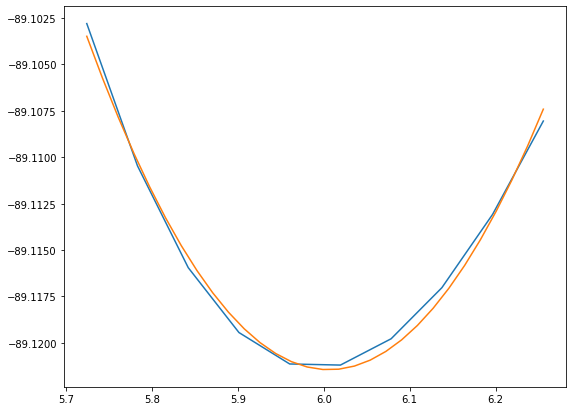

In [21]:
plt.figure(figsize=(9,7))
y = [results[ind] for ind in range(len(study.ids))]
x = [alat*(1+a/100) for a in alat_span]
x_fit = np.linspace(x[0],x[-1],30)
coeffs = np.polyfit(x,y,2)
y_fit = [coeffs[0]*xx**2+coeffs[1]*xx+coeffs[2] for xx in x_fit]
plt.plot(x,y)
plt.plot(x_fit,y_fit)

In [23]:
alat_conv = -coeffs[1]/(2*coeffs[0])
alat_conv

6.006283814677943

Then we perform a convergence on delta using the alat_conv as lattice constant

In [39]:
delta_span = np.linspace(-4,3,8)
delta_span

array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.])

In [40]:
study = D.Dataset(run_dir=run_dir,num_tasks=2)

inp.set_lattice(ibrav=4,celldm1=alat_conv,celldm3=c/alat_conv)
for d_span in delta_span:
    d = delta*(1+d_span/100)    
    Mo_cart = np.array([0,1./np.sqrt(3.),0.])
    S1_cart = np.array([1./2.,1./(2*np.sqrt(3.)),d])
    S2_cart = np.array([1./2.,1./(2*np.sqrt(3.)),-d])
    inp.set_atomic_positions([['Mo',Mo_cart],['S',S1_cart],['S',S2_cart]],type='alat')
    idd = {'delta' : d_span}
    inp.set_prefix(D.name_from_id(idd))
    study.append_run(id=idd,input=inp,runner=code)
    
study.set_postprocessing_function(PP.pw_get_energy)

Initialize a Dataset with 2 parallel tasks


In [41]:
study.ids

[{'delta': -4.0},
 {'delta': -3.0},
 {'delta': -2.0},
 {'delta': -1.0},
 {'delta': 0.0},
 {'delta': 1.0},
 {'delta': 2.0},
 {'delta': 3.0}]

In [42]:
#study.runs[0]

In [43]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7] with the parallel task_groups [[0, 1], [2, 3], [4, 5], [6, 7]] 

Run the task [0, 1] 
run command: mpirun -np 16 pw.x -inp delta_-4.0.in > delta_-4.0.log
Skip the run of slurm submit: delta_-3.0 
cd DFT_analysis-sg15 ; sbatch job_delta_-4.0.sh
computation delta_-4.0 is running...
computation delta_-4.0 ended
Task [0, 1] ended 
 
Run the task [2, 3] 
Skip the run of delta_-2.0
Skip the run of delta_-1.0
Task [2, 3] ended 
 
Run the task [4, 5] 
Skip the run of delta_0.0
Skip the run of delta_1.0
Task [4, 5] ended 
 
Run the task [6, 7] 
Skip the run of delta_2.0Skip the run of
 delta_3.0
Task [6, 7] ended 
 


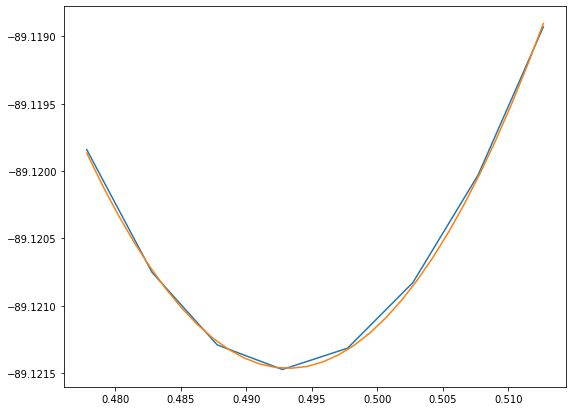

In [44]:
plt.figure(figsize=(9,7))
y = [results[ind] for ind in range(len(study.ids))]
x = [delta*(1+d/100) for d in delta_span]
x_fit = np.linspace(x[0],x[-1],30)
coeffs = np.polyfit(x,y,2)
y_fit = [coeffs[0]*xx**2+coeffs[1]*xx+coeffs[2] for xx in x_fit]
plt.plot(x,y)
plt.plot(x_fit,y_fit)

In [45]:
delta_conv = -coeffs[1]/(2*coeffs[0])
delta_conv

0.4931997773669411

Lastly, we perform a further convergence on alat to check the alat_conv value
is preserved by the modified value of delta

In [47]:
alat_span = np.linspace(-2,2,9) #7
alat_span

array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ])

In [49]:
study = D.Dataset(run_dir=run_dir,num_tasks=3)

Mo_cart = np.array([0,1./np.sqrt(3.),0.])
S1_cart = np.array([1./2.,1./(2*np.sqrt(3.)),delta_conv])
S2_cart = np.array([1./2.,1./(2*np.sqrt(3.)),-delta_conv])
inp.set_atomic_positions([['Mo',Mo_cart],['S',S1_cart],['S',S2_cart]],type='alat')

for a_span in alat_span:
    a = alat_conv*(1+a_span/100)
    idd = {'alat' : a_span,'delta':'converged'}
    inp.set_prefix(D.name_from_id(idd))
    inp.set_lattice(ibrav=4,celldm1=a,celldm3=c/a)
    study.append_run(id=idd,input=inp,runner=code)
    
study.set_postprocessing_function(PP.pw_get_energy)

Initialize a Dataset with 3 parallel tasks


In [50]:
#study.ids

In [51]:
#study.runs[2]

In [52]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7, 8] with the parallel task_groups [[0, 1, 2], [3, 4, 5], [6, 7, 8]] 

Run the task [0, 1, 2] 
run command: mpirun -np 16 pw.x -inp alat_-2.0-delta_converged.in > alat_-2.0-delta_converged.log
slurm submit: run command: mpirun -np 16 pw.x -inp alat_-1.5-delta_converged.in > alat_-1.5-delta_converged.log 
cd DFT_analysis-sg15 ; sbatch job_alat_-2.0-delta_converged.sh
slurm submit: run command: mpirun -np 16 pw.x -inp alat_-1.0-delta_converged.in > alat_-1.0-delta_converged.log 
cd DFT_analysis-sg15 ; sbatch job_alat_-1.5-delta_converged.sh
slurm submit:  cd DFT_analysis-sg15 ; sbatch job_alat_-1.0-delta_converged.sh
computation alat_-2.0-delta_converged is running...
computation alat_-1.5-delta_converged is running...
computation alat_-1.0-delta_converged is running...
computation alat_-2.0-delta_converged ended
computation alat_-1.0-delta_converged ended
computation alat_-1.5-delta_converged ended
Task [0, 1, 2] ended 
 
Run the task [3, 4, 5] 


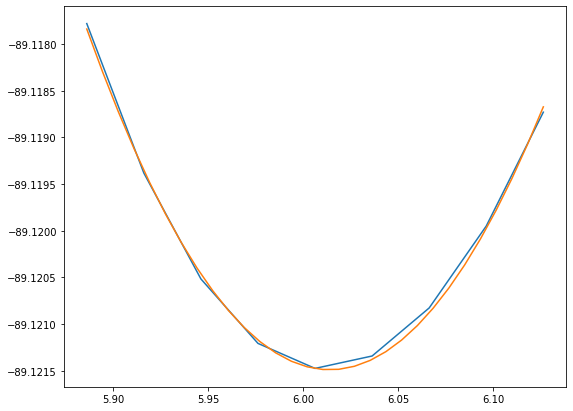

In [53]:
plt.figure(figsize=(9,7))
y = [results[ind] for ind in range(len(study.ids))]
x = [alat_conv*(1+a/100) for a in alat_span]
x_fit = np.linspace(x[0],x[-1],30)
coeffs = np.polyfit(x,y,2)
y_fit = [coeffs[0]*xx**2+coeffs[1]*xx+coeffs[2] for xx in x_fit]
plt.plot(x,y)
plt.plot(x_fit,y_fit)

In [54]:
alat_conv_new = -coeffs[1]/(2*coeffs[0])
alat_conv,alat_conv_new

(6.006283814677943, 6.014062941283385)

We observe that the alat_conv is stable within the second digit so we consider the
convergence process completed.

Finally we set

In [55]:
alat_conv = 6.014
delta_conv = 0.4932

Mo_cart = np.array([0,1./np.sqrt(3.),0.])
S1_cart = np.array([1./2.,1./(2*np.sqrt(3.)),delta_conv])
S2_cart = np.array([1./2.,1./(2*np.sqrt(3.)),-delta_conv])
inp.set_atomic_positions([['Mo',Mo_cart],['S',S1_cart],['S',S2_cart]],type='alat')
inp.set_lattice(ibrav=4,celldm1=alat_conv,celldm3=c/alat_conv)
inp

{'control': {'calculation': "'scf'",
  'verbosity': "'high'",
  'prefix': "'alat_2.0-delta_converged'",
  'outdir': "'./'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'nbnd': 28,
  'lspinorb': '.true.',
  'noncolin': '.true.',
  'ntyp': '2',
  'nat': '3',
  'ibrav': 4,
  'celldm(1)': 6.014,
  'celldm(3)': 6.651147322913202,
  'ecutwfc': 80},
 'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
 'ions': {},
 'cell': {},
 'atomic_species': {'Mo': [42.0, 'Mo_ONCV_PBE_FR-1.0.upf'],
  'S': [16.0, 'S_ONCV_PBE_FR-1.1.upf']},
 'atomic_positions': {'type': 'alat',
  'values': [['Mo', array([0.        , 0.57735027, 0.        ])],
   ['S', array([0.5       , 0.28867513, 0.4932    ])],
   ['S', array([ 0.5       ,  0.28867513, -0.4932    ])]]},
 'kpoints': {'type': 'automatic', 'values': ([12, 12, 1], [0.0, 0.0, 0.0])},
 'cell_parameters': {}}

We can express these parameters in Angstrom

In [56]:
alat_conv*U.Constants.Bohr_to_Angstrom

3.182471975486

In [57]:
delta_conv*alat_conv*U.Constants.Bohr_to_Angstrom*2

3.13919035661939

### Converged ground states

Finally we perform a last scf calculation with converged parameters

In [32]:
pseudo_dir = '../pseudos'
Mo_pseudo = 'Mo_ONCV_PBE_FR-1.0.upf'
S_pseudo = 'S_ONCV_PBE_FR-1.1.upf'
run_dir = 'DFT_analysis-sg15'

alat_conv = 6.014
delta_conv = 0.4932
c = 40.0 # vacuum distance in a.u. 

ecut = 80 # energy cutoff on the wavefunction (Ry)
kpoints = [12,12,1]

Mo_cart = np.array([0,1./np.sqrt(3.),0.])
S1_cart = np.array([1./2.,1./(2*np.sqrt(3.)),delta_conv])
S2_cart = np.array([1./2.,1./(2*np.sqrt(3.)),-delta_conv])

inp = I.PwInput()
inp.set_scf(force_symmorphic=True,conv_thr=1e-6)
inp.set_num_bnds(28)
inp.set_pseudo_dir(pseudo_dir=pseudo_dir)
inp.set_spinorbit()
inp.add_atom(atom='Mo',pseudo_name=Mo_pseudo,mass=42.00)
inp.add_atom(atom='S',pseudo_name=S_pseudo,mass=16.00)
inp.set_atoms_number(3)
inp.set_atomic_positions([['Mo',Mo_cart],['S',S1_cart],['S',S2_cart]],type='alat')
inp.set_lattice(ibrav=4,celldm1=alat_conv,celldm3=c/alat_conv)
inp.set_energy_cutoff(ecut)
inp.set_kpoints(type='automatic',points=kpoints)
inp

{'control': {'calculation': "'scf'",
  'verbosity': "'high'",
  'prefix': "'pwscf'",
  'outdir': "'./'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'nbnd': 28,
  'lspinorb': '.true.',
  'noncolin': '.true.',
  'ntyp': '2',
  'nat': '3',
  'ibrav': 4,
  'celldm(1)': 6.014,
  'celldm(3)': 6.651147322913202,
  'ecutwfc': 80},
 'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
 'ions': {},
 'cell': {},
 'atomic_species': {'Mo': [42.0, 'Mo_ONCV_PBE_FR-1.0.upf'],
  'S': [16.0, 'S_ONCV_PBE_FR-1.1.upf']},
 'atomic_positions': {'type': 'alat',
  'values': [['Mo', array([0.        , 0.57735027, 0.        ])],
   ['S', array([0.5       , 0.28867513, 0.4932    ])],
   ['S', array([ 0.5       ,  0.28867513, -0.4932    ])]]},
 'kpoints': {'type': 'automatic', 'values': ([12, 12, 1], [0.0, 0.0, 0.0])},
 'cell_parameters': {}}

In [60]:
study = D.Dataset(run_dir=run_dir,num_tasks=1)

idd = 'gs_converged'
inp.set_prefix(D.name_from_id(idd))
study.append_run(id=idd,input=inp,runner=code)
study.set_postprocessing_function(PP.pw_parse_data)

Initialize a Dataset with 1 parallel tasks


In [61]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
run command: mpirun -np 16 pw.x -inp gs_converged.in > gs_converged.log
slurm submit:  cd DFT_analysis-sg15 ; sbatch job_gs_converged.sh
computation gs_converged is running...
computation gs_converged ended
Task [0] ended 
 


In [62]:
results[0].get_gap()

Direct gap system
Gap : 1.6229154360808367 eV


{'gap': 1.6229154360808367,
 'direct_gap': 1.6229154360808367,
 'position_cbm': 18,
 'position_vbm': 18,
 'position_direct_gap': 18}

Gap at $\Gamma$

In [63]:
results[0].get_evals()[0][26]- results[0].get_evals()[0][25]

2.7457350535000655

### Band structure on high symmetry line

Now we perform the bands computation specifying the kpoints on a path. 

To define the path we write the coordinates of the high symmetry points (using the tpiba_b type of
pw) and we make usage of the function build_kpath

In [64]:
bands_prefix = 'bands'
G = [0.,0.,0.]
Kp = [1./3.,1./np.sqrt(3),0.]
Mp = [0.,1./np.sqrt(3),0.]
high_sym = {'G':G,'K':Kp,'M':Mp} # useful to label the high-sym point on the path

In [65]:
klist = Tools.build_pw_kpath(G,Mp,Kp,G,numstep=40)
klist

[[0.0, 0.0, 0.0, 40],
 [0.0, 0.5773502691896258, 0.0, 40],
 [0.3333333333333333, 0.5773502691896258, 0.0, 40],
 [0.0, 0.0, 0.0, 0]]

In [66]:
inp.set_bands(30,force_symmorphic=True,conv_thr=1e-6)
inp.set_prefix(bands_prefix)
inp.set_kpoints(type='tpiba_b',klist=klist)
inp

{'control': {'calculation': "'bands'",
  'verbosity': "'high'",
  'prefix': "'bands'",
  'outdir': "'./'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'nbnd': 30,
  'lspinorb': '.true.',
  'noncolin': '.true.',
  'ntyp': '2',
  'nat': '3',
  'ibrav': 4,
  'celldm(1)': 6.014,
  'celldm(3)': 6.651147322913202,
  'ecutwfc': 80},
 'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
 'ions': {},
 'cell': {},
 'atomic_species': {'Mo': [42.0, 'Mo_ONCV_PBE_FR-1.0.upf'],
  'S': [16.0, 'S_ONCV_PBE_FR-1.1.upf']},
 'atomic_positions': {'type': 'alat',
  'values': [['Mo', array([0.        , 0.57735027, 0.        ])],
   ['S', array([0.5       , 0.28867513, 0.4932    ])],
   ['S', array([ 0.5       ,  0.28867513, -0.4932    ])]]},
 'kpoints': {'type': 'tpiba_b',
  'values': [[0.0, 0.0, 0.0, 40],
   [0.0, 0.5773502691896258, 0.0, 40],
   [0.3333333333333333, 0.5773502691896258, 0.0, 40],
   [0.0, 0.0, 0.0, 0]]},
 'cell_parameters': {}}

In [67]:
results = code.run(input=inp,run_dir=run_dir,name=bands_prefix,source_dir='DFT_analysis-sg15/gs_converged.save')

copy source_dir DFT_analysis-sg15/gs_converged.save in the /work/dalessandro/TMDs/MoS2/DFT_analysis-sg15/bands.save
run command: mpirun -np 16 pw.x -inp bands.in > bands.log
slurm submit:  cd DFT_analysis-sg15 ; sbatch job_bands.sh
computation bands is running...
computation bands ended


Once that the computation is over we can create an instance of PwBands

In [68]:
bands = U.BandStructure.from_Pw(results,high_sym)

In [69]:
bands.get_high_sym_positions()

(['$\\Gamma$', '$\\Gamma$', 'K', 'M'],
 [0.0, 1.5773502657018035, 0.9106835999999987, 0.57735027])

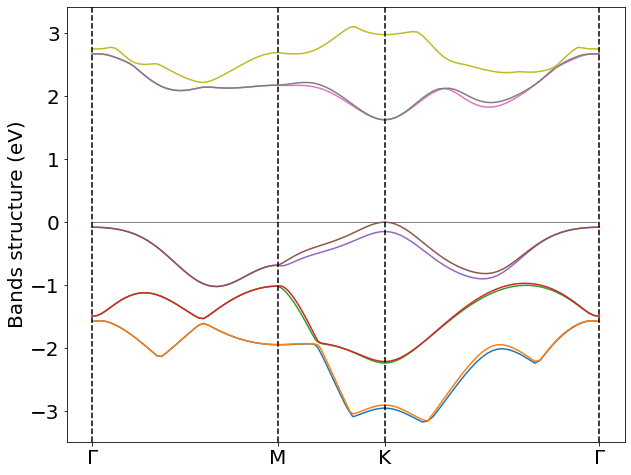

In [70]:
label_size = 20

fig, ax = plt.subplots(figsize=(10, 8))
#ax.set_ylim(-5,7)
bands.plot(plt,selection=[i for i in range(20,29)])
ax.hlines(0.,0.,1.57,linestyles='-',color='gray',linewidth=1)
ax.set_ylabel('Bands structure (eV)',size=label_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)

#plt.savefig(fname='Plot/band_structure.eps',format='eps',bbox_inches = "tight")

Compute the difference between the conduction energy at K and at the minimum value in the K valley

In [81]:
minind = argrelextrema(-bands.bands[26],np.greater,order=3)[0]
print(minind)
print(bands.kpath[minind])
print(bands.bands[26][minind])
bands.bands[26][minind[3]]-bands.bands[26][minind[4]]

[19 29 43 80 99]
[0.27424138 0.41857895 0.60235027 0.9106836  1.22735027]
[2.08542712 2.1248401  2.16671971 1.62153439 1.82194539]


-0.2004109952388642

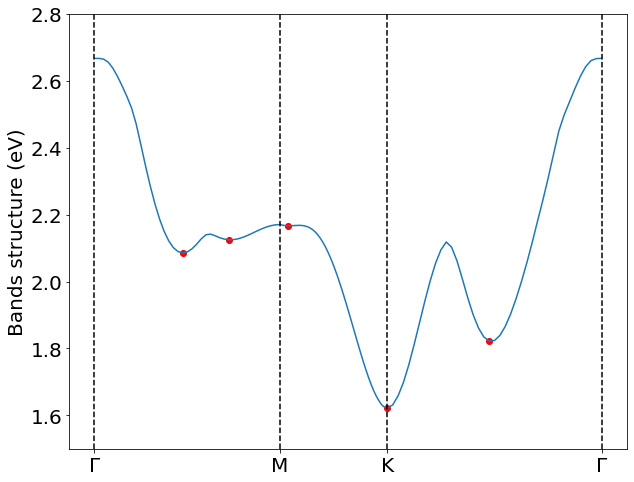

In [83]:
fig, ax = plt.subplots(figsize=(10, 8))
#ax.set_ylim(-5,7)
bands.plot(plt,selection=[26])
ax.scatter(bands.kpath[minind],bands.bands[26][minind],c='r')
ax.hlines(0.,0.,1.57,linestyles='-',color='gray',linewidth=1)
ax.set_ylabel('Bands structure (eV)',size=label_size)
ax.set_ylim(1.5,2.8)
ax.tick_params(axis='both', which='major', labelsize=label_size)

### NSCF computations on regular grids

We set up the nscf computations on regular grids.

In [33]:
Gamma = np.array([0.,0.])
K = np.array([2./3.,0])
M = np.array([1./2.,1./(2*np.sqrt(3))])
Kp = np.array([1./3.,1./np.sqrt(3)])
Mp = np.array([0.,1./np.sqrt(3)])

In [34]:
nbnds = 250
inp.set_nscf(nbnds,force_symmorphic=True,conv_thr=1e-6)

In [35]:
kvalues = [24] #[18,30,42]

In [36]:
study = D.Dataset(run_dir=run_dir,num_tasks=1)
study.set_postprocessing_function(PP.pw_parse_data)

for k in kvalues:
    idd = {'kpoints':k,'nbnds':nbnds}
    inp.set_prefix(D.name_from_id(idd))
    inp.set_kpoints(points=[k,k,1])
    study.append_run(id=idd,input=inp,runner=code,source_dir='DFT_analysis-sg15/gs_converged.save')

Initialize a Dataset with 1 parallel tasks


In [37]:
study.runs[0]

{'label': 'Dataset',
 'run_dir': 'DFT_analysis-sg15',
 'num_tasks': 1,
 'verbose': True,
 'input': {'control': {'calculation': "'nscf'",
   'verbosity': "'high'",
   'prefix': "'kpoints_24-nbnds_250'",
   'outdir': "'./'",
   'pseudo_dir': "'../pseudos'"},
  'system': {'force_symmorphic': '.true.',
   'nbnd': 250,
   'lspinorb': '.true.',
   'noncolin': '.true.',
   'ntyp': '2',
   'nat': '3',
   'ibrav': 4,
   'celldm(1)': 6.014,
   'celldm(3)': 6.651147322913202,
   'ecutwfc': 80},
  'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
  'ions': {},
  'cell': {},
  'atomic_species': {'Mo': [42.0, 'Mo_ONCV_PBE_FR-1.0.upf'],
   'S': [16.0, 'S_ONCV_PBE_FR-1.1.upf']},
  'atomic_positions': {'type': 'alat',
   'values': [['Mo', array([0.        , 0.57735027, 0.        ])],
    ['S', array([0.5       , 0.28867513, 0.4932    ])],
    ['S', array([ 0.5       ,  0.28867513, -0.4932    ])]]},
  'kpoints': {'type': 'automatic', 'values': ([24, 24, 1], [0.0, 0.0, 0.0])},
  'cell_parame

In [38]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
copy source_dir DFT_analysis-sg15/gs_converged.save in the /work/dalessandro/TMDs/MoS2/DFT_analysis-sg15/kpoints_24-nbnds_250.save
run command: mpirun -np 16 pw.x -inp kpoints_24-nbnds_250.in > kpoints_24-nbnds_250.log
slurm submit:  cd DFT_analysis-sg15 ; sbatch job_kpoints_24-nbnds_250.sh
computation kpoints_24-nbnds_250 is running...
computation kpoints_24-nbnds_250 ended
Task [0] ended 
 


In [15]:
kp = results[0].kpoints # cartesian coordinates in units of 2\pi/alat

number of kpoints = 169


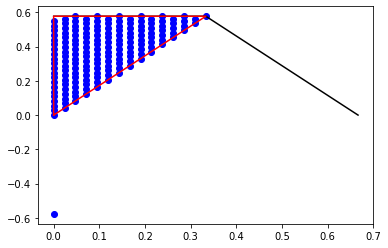

In [16]:
BZ = [K, Kp, Mp]
print('number of kpoints = %s'%len(kp))
plt.plot(*np.column_stack(BZ),color='black')
IBZ = [Gamma,Kp, Mp,Gamma]
plt.plot(*np.column_stack(IBZ),color='red')
plt.scatter(kp[:,0],kp[:,1],c='blue')

### Analysis of the _assume isolated_ option

We test the effect of the introduction of the Coulomb cutoff at he DFT level.

We use the converged parameters found above.

In [5]:
pseudo_dir = '../pseudos'
Mo_pseudo = 'Mo_ONCV_PBE_FR-1.0.upf'
S_pseudo = 'S_ONCV_PBE_FR-1.1.upf'
run_dir = 'DFT_analysis-sg15'

alat_conv = 6.014
delta_conv = 0.4932
c = 40.0 # vacuum distance in a.u. 

ecut = 80 # energy cutoff on the wavefunction (Ry)
kpoints = [12,12,1]

Mo_cart = np.array([0,1./np.sqrt(3.),0.])
S1_cart = np.array([1./2.,1./(2*np.sqrt(3.)),delta_conv])
S2_cart = np.array([1./2.,1./(2*np.sqrt(3.)),-delta_conv])

inp = I.PwInput()
inp.set_scf(force_symmorphic=True,conv_thr=1e-6)
inp['system']['assume_isolated']= '2D'
inp.set_num_bnds(28)
inp.set_pseudo_dir(pseudo_dir=pseudo_dir)
inp.set_spinorbit()
inp.add_atom(atom='Mo',pseudo_name=Mo_pseudo,mass=42.00)
inp.add_atom(atom='S',pseudo_name=S_pseudo,mass=16.00)
inp.set_atoms_number(3)
inp.set_atomic_positions([['Mo',Mo_cart],['S',S1_cart],['S',S2_cart]],type='alat')
inp.set_lattice(ibrav=4,celldm1=alat_conv,celldm3=c/alat_conv)
inp.set_energy_cutoff(ecut)
inp.set_kpoints(type='automatic',points=kpoints)
inp

{'control': {'calculation': "'scf'",
  'verbosity': "'high'",
  'prefix': "'pwscf'",
  'outdir': "'./'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'assume_isolated': '2D',
  'nbnd': 28,
  'lspinorb': '.true.',
  'noncolin': '.true.',
  'ntyp': '2',
  'nat': '3',
  'ibrav': 4,
  'celldm(1)': 6.014,
  'celldm(3)': 6.651147322913202,
  'ecutwfc': 80},
 'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
 'ions': {},
 'cell': {},
 'atomic_species': {'Mo': [42.0, 'Mo_ONCV_PBE_FR-1.0.upf'],
  'S': [16.0, 'S_ONCV_PBE_FR-1.1.upf']},
 'atomic_positions': {'type': 'alat',
  'values': [['Mo', array([0.        , 0.57735027, 0.        ])],
   ['S', array([0.5       , 0.28867513, 0.4932    ])],
   ['S', array([ 0.5       ,  0.28867513, -0.4932    ])]]},
 'kpoints': {'type': 'automatic', 'values': ([12, 12, 1], [0.0, 0.0, 0.0])},
 'cell_parameters': {}}

In [6]:
study = D.Dataset(run_dir=run_dir,num_tasks=1)

idd = 'gs_converged-assume_isolated'
inp.set_prefix(D.name_from_id(idd))
study.append_run(id=idd,input=inp,runner=code)
study.set_postprocessing_function(PP.pw_parse_data)

Initialize a Dataset with 1 parallel tasks


In [7]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
run command: mpirun -np 16 pw.x -inp gs_converged-assume_isolated.in > gs_converged-assume_isolated.log
slurm submit:  cd DFT_analysis-sg15 ; sbatch job_gs_converged-assume_isolated.sh
computation gs_converged-assume_isolated is running...
computation gs_converged-assume_isolated ended
Task [0] ended 
 


In [8]:
results[0].get_gap()

Direct gap system
Gap : 1.6231410879251271 eV


{'gap': 1.6231410879251271,
 'direct_gap': 1.6231410879251271,
 'position_cbm': 18,
 'position_vbm': 18,
 'position_direct_gap': 18}

Gap at $\Gamma$

In [9]:
results[0].get_evals()[0][26]- results[0].get_evals()[0][25]

2.7455382728148225

Now we perform the bands computation specifying the kpoints on a path. 

To define the path we write the coordinates of the high symmetry points (using the tpiba_b type of
pw) and we make usage of the function build_kpath

In [13]:
bands_prefix = 'bands-assume_isolated'
G = [0.,0.,0.]
Kp = [1./3.,1./np.sqrt(3),0.]
Mp = [0.,1./np.sqrt(3),0.]
high_sym = {'G':G,'K':Kp,'M':Mp} # useful to label the high-sym point on the path

In [14]:
klist = Tools.build_pw_kpath(G,Mp,Kp,G,numstep=40)
klist

[[0.0, 0.0, 0.0, 40],
 [0.0, 0.5773502691896258, 0.0, 40],
 [0.3333333333333333, 0.5773502691896258, 0.0, 40],
 [0.0, 0.0, 0.0, 0]]

In [16]:
inp.set_bands(30,force_symmorphic=True,conv_thr=1e-6)
inp.set_prefix(bands_prefix)
inp.set_kpoints(type='tpiba_b',klist=klist)
inp

{'control': {'calculation': "'bands'",
  'verbosity': "'high'",
  'prefix': "'bands-assume_isolated'",
  'outdir': "'./'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'assume_isolated': '2D',
  'nbnd': 30,
  'lspinorb': '.true.',
  'noncolin': '.true.',
  'ntyp': '2',
  'nat': '3',
  'ibrav': 4,
  'celldm(1)': 6.014,
  'celldm(3)': 6.651147322913202,
  'ecutwfc': 80},
 'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
 'ions': {},
 'cell': {},
 'atomic_species': {'Mo': [42.0, 'Mo_ONCV_PBE_FR-1.0.upf'],
  'S': [16.0, 'S_ONCV_PBE_FR-1.1.upf']},
 'atomic_positions': {'type': 'alat',
  'values': [['Mo', array([0.        , 0.57735027, 0.        ])],
   ['S', array([0.5       , 0.28867513, 0.4932    ])],
   ['S', array([ 0.5       ,  0.28867513, -0.4932    ])]]},
 'kpoints': {'type': 'tpiba_b',
  'values': [[0.0, 0.0, 0.0, 40],
   [0.0, 0.5773502691896258, 0.0, 40],
   [0.3333333333333333, 0.5773502691896258, 0.0, 40],
   [0.0, 0.0, 0.0, 0]]},
 '

In [17]:
results = code.run(input=inp,run_dir=run_dir,name=bands_prefix,source_dir='DFT_analysis-sg15/gs_converged-assume_isolated.save')

copy source_dir DFT_analysis-sg15/gs_converged-assume_isolated.save in the /work/dalessandro/TMDs/MoS2/DFT_analysis-sg15/bands-assume_isolated.save
run command: mpirun -np 16 pw.x -inp bands-assume_isolated.in > bands-assume_isolated.log
slurm submit:  cd DFT_analysis-sg15 ; sbatch job_bands-assume_isolated.sh
computation bands-assume_isolated is running...
computation bands-assume_isolated ended


Once that the computation is over we can create an instance of PwBands

In [18]:
bands = U.BandStructure.from_Pw(results,high_sym)

In [19]:
bands.get_high_sym_positions()

(['$\\Gamma$', '$\\Gamma$', 'K', 'M'],
 [0.0, 1.5773502657018035, 0.9106835999999987, 0.57735027])

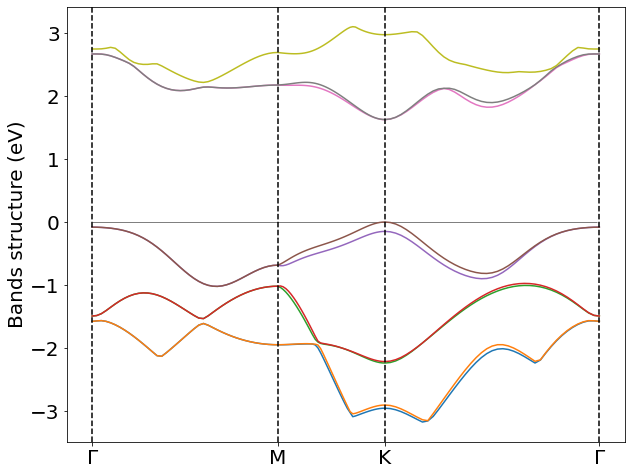

In [20]:
label_size = 20

fig, ax = plt.subplots(figsize=(10, 8))
#ax.set_ylim(-5,7)
bands.plot(plt,selection=[i for i in range(20,29)])
ax.hlines(0.,0.,1.57,linestyles='-',color='gray',linewidth=1)
ax.set_ylabel('Bands structure (eV)',size=label_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)

#plt.savefig(fname='Plot/band_structure.eps',format='eps',bbox_inches = "tight")

We compare the results with non isolated system

In [22]:
bands_old = U.BandStructure.from_Pw('DFT_analysis-sg15/bands.save/data-file-schema.xml',high_sym)

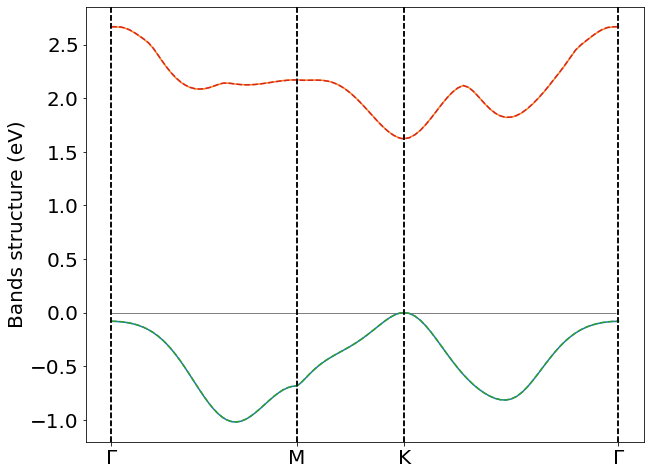

In [31]:
label_size = 20

fig, ax = plt.subplots(figsize=(10, 8))
bands.plot(plt,selection=[25,26],linestyle='-')
bands_old.plot(plt,selection=[25,26],linestyle='--')
ax.hlines(0.,0.,1.57,linestyles='-',color='gray',linewidth=1)
ax.set_ylabel('Bands structure (eV)',size=label_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)


We observe that the Coulomb cutoff at the DFT level has no impact on the band structure.